<a href="https://colab.research.google.com/github/cynthiazhiyi/msba_trial/blob/main/Analytics4GoodHumana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humana Case Competition Notebook

### 1. Motivation and opportunity

Oncology is a clinical area of focus that has seen significant advances in research and new therapies. Despite these advances, cancer remains a leading cause of death, with approximately 600,000 people dying from cancer each year in the US alone. While new treatments are coming to the market, many of them are associated with potentially significant side effects which are a barrier to people staying adherent to their life-saving medications.

One of these medications is Osimertinib, an oral tyrosine kinase inhibitor used for patients in early-stage lung cancer of the non-small cell variety, with a specific targetable mutation known as EGFR. Osimertinib is known to be a largely effective medication, with patients receiving it being twice as likely to survive compared to those who do not take the medication. Additionally, patients taking the medication as prescribed are 80% less likely to have a recurrence of their cancer.

As with many other oncology drugs, tolerance of Osimertinib can be difficult due to the side effects associated with the medication—specifically nausea, fatigue, pain, high blood glucose, and constipation. Many of these side effects are manageable with proper counseling and avoidance techniques, but many patients may opt to discontinue their treatment rather than seeking guidance on how to manage them. Approximately one quarter of Humana members taking Osimertinib have side effects and discontinue their Osimertinib therapy within the first 6 months.

To address this problem, we need to leverage our data and analytics to target members at risk, encourage medication adherence, and allow our oncology patients to live longer, fulfilling lives.

### 2. Predicting Modeling Target

As explained previously, taking Osimertinib as prescribed can help people live longer, but treatable side-effects might cause people to end their treatment prematurely. To this end, your assignment is to build a model to predict which therapies will end prematurely after a reported side effect, also known as an adverse drug event or ADE.

It is in everyone’s best interest for a patient to keep taking their Osimertinib therapy for as long as possible. In this case, a successful therapy is six months (180 days) of continuous Osimertinib therapy. Conversely, an unsuccessful therapy is any therapy that ends before 180 days. However, to specifically target members who may be discontinuing due to experiencing an ADE, we’ve defined the target more specifically to include an ADE at some point during the unsuccessful therapy. In the training data, this target is recorded in the column labeled `tgt_ade_dc_ind`.

#### 2.1. Unsuccessful Therapy: TGT_ADE_DC_IND==1

The target is defined as a therapy that ends prematurely (before 180 days) and has an ADE reported at some time during the therapy. The target definition has already been done for you and is available in target_train.csv as the column ‘tgt_ade_dc_ind’.

#### 2.1.2. All other Therapies: TGT_ADE_DC_IND==0

Since the target definition is so specific, there are several other types of therapies not included in the target group. The following are a few examples:

- Successful therapies with 180 days of continuous treatment
-	Therapies that end prematurely with no reported ADEs
-	Therapies where the member changes to another insurance plan or dies before 180 days

### 3. Available Data

Since we’re trying to predict if a therapy will end prematurely after an ADE, our data is organized based on a specific therapy with one member, a start date and end date.
Each category of data is separated into a train and holdout set. Use the train set to train your model and submit your predictions on the holdout set for scoring.

#### 3.1. File Descriptions

The following sections provide a brief overview of the available data. Detailed descriptions of all fields are available in data_dictionary.csv.
With the exception of the target_holdout, the target and holdout sets contain the exact same data columns, but for different sets of individuals.

##### 3.1.1. Target: target_train (1232 records), target_holdout (420 records)

Unique on the person identifier and therapy identifier. Contains information about the therapy start and end dates, the target identifier, and protected attributes for the individual (sex, race, age, etc.)
Important Note: When you submit your results for Round 1, you will need to submit an ID, score and rank for each individual ID in the target_holdout file. The ID will come directly from target_holdout.csv, and the score and rank will come from your predictive model. You will notice that there is no target identifier or therapy end date included in target_holdout.csv.

Sum of tgt_ade_dc_ind in target_train.csv: 117

##### 3.1.2. Medical Claims: medclms_train (100159 records), medclms_holdout (23232 records)

Unique on claim identifier. Contains simplified information about all medical claims for an individual during the time 90 days before their Osimertinib therapy and through the end of therapy. This data includes visit and process dates, diagnosis codes and indicators for diagnosis codes of interest. E.g. since nausea is a known side-effect of Osimertinib, we added an indicator column for a diagnosis code related to nausea.

#### 3.2. Pharmacy Claims: rxclms_train (32133 records), rxclms_holdout (6670 records)

Unique on claim identifier. Contains simplified information about all pharmacy claims for an individual during the time 90 days before their Osimertinib therapy and through the end of therapy. This data includes service and process dates, drug identifier codes (NDC) and indicators for drug codes of interest. E.g. since anticoagulants are a known to have drug interactions with Osimertinib, we added an indicator column for a drug code for an anticoagulant.

Average rx_cost in rxclms_train: 2463.950

Average rx_cost in rxclms_holdout: 2159.679

#### 3.2.1. Data Dictionary: data_dictionary.csv (49 records)
Contains a description for each data column available in the claims datasets.

#### 3.2.2. Race Code Descriptions: race_cd_desc.csv (7 records)
Contains definitions for the coded race codes in the target files.





## Import Libraries here

Please import any Python library you want to use here to keep things clean

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Define the Functions Here

Please define any function you would like to use here to keep things clean

In [ ]:
def explain_field(field):
  ''' This function takes in a field and returns an explanation from the data dictionary'''
  return data_dictionary[data_dictionary['field'] == field]['definition'].iloc[0]

In [ ]:
def flatten_list(nested_list):
  ''' This function is used to flatten a list from a nested list. It is used in data preprocessing of rxclms_train'''
  flat_list = []
  for item in nested_list:
      if isinstance(item, list):
          flat_list.extend(flatten_list(item))
      else:
          flat_list.append(item)
  return flat_list

## Section 1: Data Dictionary

In this section, we import the data dictionary provided by Humana. In this case, we can always refer back to it in case of any ambiguities.

In [ ]:
#connect to google drive so that anyone can open the data set
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#upload data_dictionary file
uploaded = files.upload()

Saving data_dictionary.csv to data_dictionary.csv


In [ ]:
# Identify the file name
file_name = list(uploaded.keys())[0]
file_name

'data_dictionary.csv'

In [ ]:
#read it in pandas
data_dictionary = pd.read_csv(file_name)
data_dictionary.head()

,field,definition,table
0,id,Person Identifier - unique for a member,target_df
1,therapy_start_date,The date of the member's first fill of Tagrisso.,target_df
2,therapy_end_date,The date the member runs out of their supply o...,target_df
3,tgt_ade_dc_ind,An indicator for whether this person meets the...,target_df
4,race_cd,a numeric indicator for race,target_df


In case we need to know what any of the columns mean, such as `tgt_ade_dc_ind`, we can call the following code:

In [ ]:
data_dictionary[data_dictionary['field'] == 'tgt_ade_dc_ind']['definition'].iloc[0]

'An indicator for whether this person meets the target criteria of reporting an ADE and discontinuing therapy before 6 months. Only availble in training data'

A **function** that gives us the explanation of a field. Let us define a function which we can use later on in order to explain a field that might be confusing to us.

In [ ]:
def explain_field(field):
  ''' This function takes in a field and returns an explanation from the data dictionary'''
  return data_dictionary[data_dictionary['field'] == field]['definition'].iloc[0]

In [ ]:
#example 1
explain_field('tgt_ade_dc_ind')

'An indicator for whether this person meets the target criteria of reporting an ADE and discontinuing therapy before 6 months. Only availble in training data'

In [ ]:
#example 2
explain_field('ddi_ind')

'Indicates if this claim is for a drug with a know interaction with Tagrisso'

We can see how the function **explain_field** makes our lives easier if we are stuck trying to figure out what a field means.

## Section 2: General Considerations  

In this section, we discuss critical information and general considerations.

- It is important to understand that the targets are not only those patients that have discontinued the treatment of Osimertinib, but they are also patients who **reportedly suffered from an adverse side effect before they stopped the treatment**. Therefore, we might find a patient who stopped the treatment to be labelled **0**, only because an ADE has not been reported.
- There are three datasets provided to us: `target_train`, `rxclms_train`, and `medclms_train`: all containing important predictors of patient churn. We also have **not one but three holdout sets**. This does not mean that we need to build three models, the holdout sets are for the same individuals, and therefore we shall **join** them into one set and then produce the predictions.
- Our **main objective** is to identify patients at risk, i.e. patients who are most likely to stop their treatment after experiencing side effect complications.


## Section 3: What we want our models to learn and why?

Before we build any model, it is important to know what we want our models to learn and why. From the perspective of the cancer patient who is taking/thinking about taking Osimertinib, there is a **trade-off** between the higher chance of treatment (patients who take the medicine for 6 months are twice as likely to be cured from cancer relative to the patients who do not) and the cost of suffering from the side effects (like nausea). Therefore, it seems that the decision the patient comes to (whether to start/continue with the treatment) is **more mental than physical**. It is more of a long-term benefits vs short-term suffering type of thing. Therefore, we can assume on a high level, that there are two types of patients:

1) Type 1 (**The mentally tough patients**): Those patients value the long term benefits of curing cancer more than the short-term sufferings of the side effects of Osimertinib.
  - We assume that this cluster of patients is mentally tough, understands that to get to the "big prize", one has to suffer now. These patients always seek guidance to minimize the short-term pain, and are aware that Osimertinib is going to make them suffer, but **only temporarily**. We assume that these types of patients continue taking the drug for 6 months, despite the short term pain. Those patients have a label of 0 in our dataset, but not all 0 labels are of this type, as it is mentioned in the problem statement that it is possible for a patient who has stopped treatment within 6 months to be labelled zero if the ADE was not reported.

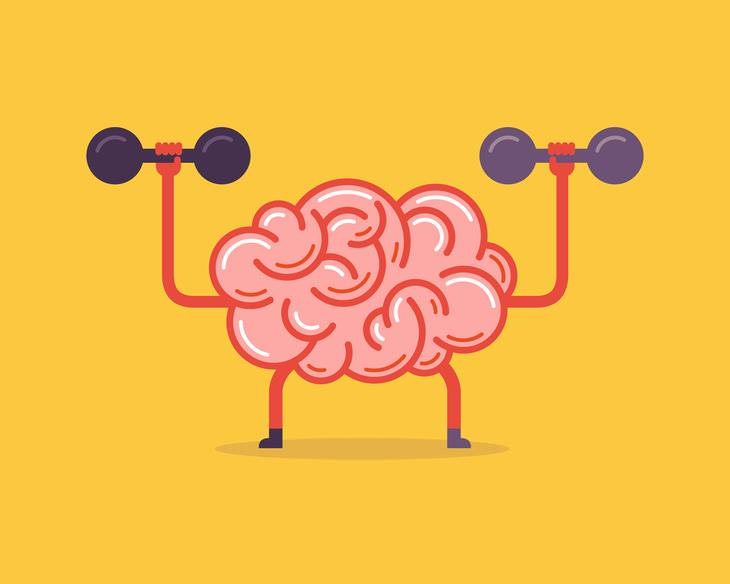


2) Type 2 (**The mentally weak patients**): Those patients are not ready to bear the short term pain for the long term rewards. This group of patients has a mindset similar to the majority of people nowadays when making daily decisions. **Our minds naturally tend to prefer the easy way out**. Everyone wants the easy road to success. For example, every person wants to be wealthy but when they are faced with the decision of whether they should stay at home and work or go out and party, most people choose the latter. Another example is fitness, every person wants to be in great shape, but when they are faced with the decision of actually going to the gym or staying home, watching Netflix and ordering pizza, most people choose the latter. **Type 2 patients** have a similar mindset: they **are not ready to endure the short term sufferings in return of the long term benefits of the medicine**. They just want a medicine that can cure cancer the easy way (i.e. without any side effects). These types of patients tend to quit early on in the process after facing a number of complications. It is those patients that have a label of 1 in our dataset. All targets that are labelled 1 in our dataset represent the mentally weak patients. This gives us a chance of exploring what the characterisitcs of this cluster are.

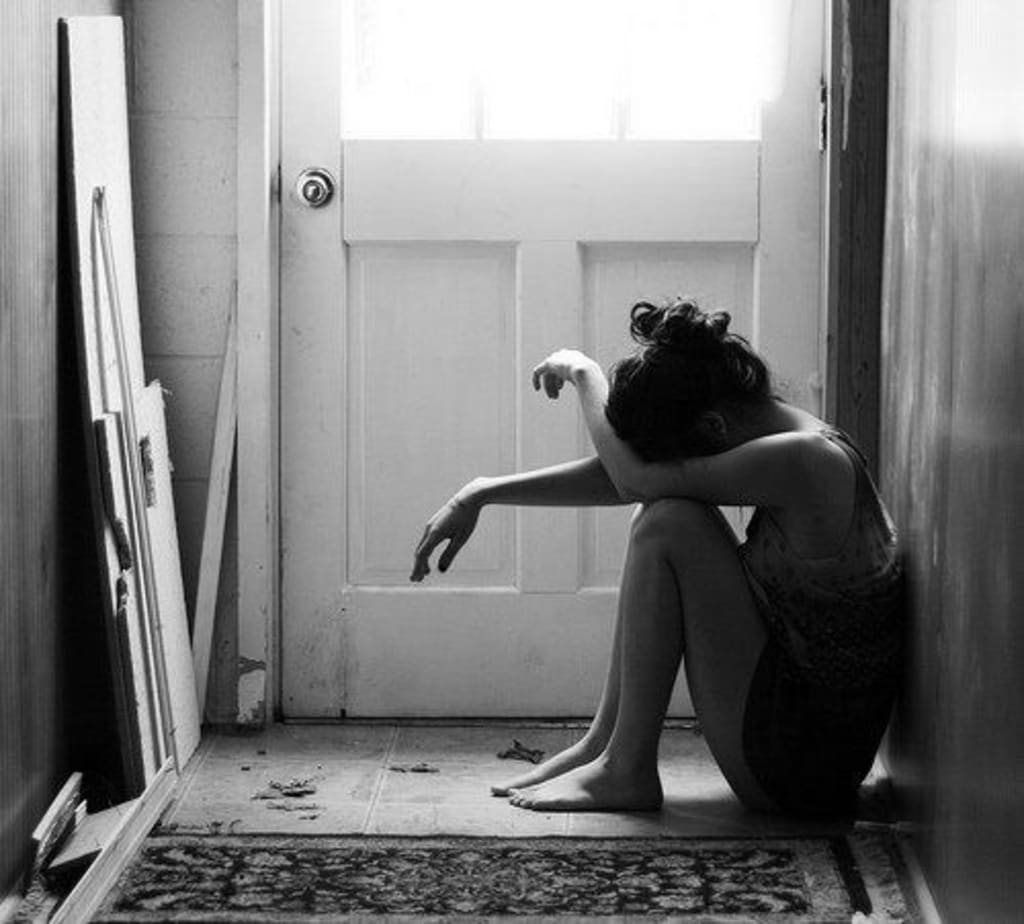

Now that we provided a general overview of the two clusters of patients, we can not only start thinking about what we want our models to learn, but **we can also start drafting recommendations for what data would be useful for predictions**. For example, one feature that is probably not provided in the dataset is **whether the patient works out/used to work out or not**. People who work out tend to have higher mental toughness than those who do not. Those people are willing to do the uncomfortable training for one hour each day for the long term gains.

It is important, however, to note that **the two clusters defined above are not sufficient to predict whether the patient is going to stop the treatment or not**, as it is affected by other factors like age. For example, even if the person is mentally tough and has cancer at an age of 90, they might think that it is not worth it to suffer for 6 months, since they do not have much to live anyways.

However, mental toughness is still an essential predictor of completing the treatment, and I argue that it should be studied thoroughly.

For that reason, if we are able to discern from our datasets what causes a patient to lose their "tolerance" for the medicine, we discover a great deal about the likelihood of the patient stopping the treatment.

**What we want our models to learn, is therefore, the predictors that significantly drag down the patient's tolerance for short term effects**. For example, having nausea might have more significance than having other side effects. Another example is age, where the elderly probably have lower tolerance than the youth, and so on.

## **Section 4: Questions and Hypotheses**

In this section, we ask questions and claim hypotheses which we think are true, to be validated later with the dataset that we have.

- **Hypothesis 1**: The **age distribution** of the positive class is skewed to the right. The reason we say this is because the elderly are more probably to give up the long term benefits of Osimertinib than the youth, since they do not have a lot to live anyway.
  - Proven in Section 5, Q3.
- **Hypothesis 2**: There are certain side effects that are more "unlikable" than others, and therefore have greater power in decreasing the tolerance of patients.
  - To be proven / disproven from the dataset
- **Hypothesis 3**: The frequency of complications affects the likelihood of giving up the treatment. For example, it is significantly different to have one complication per month versus three complications per month. The more the complications, the harder it becomes for the patient to fight, and therefore the higher the chances of giving up the treatment.
  - To be proven / disproven
- **Hypothesis 4**: Taking other drugs might negatively affect the amount/severity of ADEs reported by a patient. For example, some medications that are known to produce worse side effects when taken simultaneously with Osimertinib.
  - To be proven / disproven
- **Hypothesis 5**: Having a greater number of different side effects affects the likelihood of a patient abandoning the treatment. The more different side effects experienced by the patient (e.g. diarrhea, nausea, **and** fatigue), the more likely to abandon the treatment than if it only experiences one (e.g. only diarrhea)
  - To be proven / disproven
- **Hypothesis 6**: Having a disability might affect the patients likelihood to abandon the treatment. Patients with disabilities might be more used to being resilient and therefore, tollerate more the side effects. On the other hand, patients with disabilities migth already be suffering a lot and can't tolerate adding more suffering due to the side effects and therefore, are more likely to abandon the treatment.
  - To be proven / disproven
- **Hypothesis 7**: Low income patients and the accumulated cost of the treatment, can affect a patient's likelihood to remain/abandon the treatment.
  - To be proven / disproven
- **Hypothesis 8**: Patients that file an ADE claim in an ER/Urgent Care are might be more likely to discontinue the treatment since it reflects the severity of the side effects (use 'util_cat' in medclaims file).
  - To be proven / disproven


## **Section 5: Exploratory Data Analysis**

In this section, we explore the dataset and answer some of the questions and hypotheses posed earlier.

We have three datasets (each dataset has a train and holdout), we will start by exploring the datasets provided for training.

### **5.1. Target_train file**

In [ ]:
#upload the target_train file
uploaded = files.upload()

Saving target_train.csv to target_train.csv


In [ ]:
# Identify the file name
file_name = list(uploaded.keys())[0]
file_name

'target_train.csv'

In [ ]:
#read it in pandas
target_train = pd.read_csv(file_name)
target_train.head()

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind
0,1005597228,1005597228-TAGRISSO-1,2020-03-11T00:00:00.000+0000,2020-09-07,0,1.0,NaN,NaN,NaN,NaN
1,1005964858,1005964858-TAGRISSO-1,2021-08-23T00:00:00.000+0000,2021-09-22,1,1.0,86.0,M,0.0,0.0
2,1007548572,1007548572-TAGRISSO-1,2022-01-17T00:00:00.000+0000,2022-07-16,0,1.0,79.0,F,0.0,1.0
3,1009508044,1009508044-TAGRISSO-1,2020-01-23T00:00:00.000+0000,2020-07-21,0,1.0,70.0,F,1.0,1.0
4,1028064791,1028064791-TAGRISSO-1,2021-02-23T00:00:00.000+0000,2021-08-22,0,2.0,74.0,F,1.0,1.0


In [ ]:
#Let us first use the explain_field defined earlier to understand the columns of target_train
for i in target_train.columns:
  print(f'{i} : {explain_field(i)}')

id : Person Identifier - unique for a member
therapy_id : therapy identifier - concatenation of sdr_person_id, drug name, and therapy number
therapy_start_date : The date of the member's first fill of Tagrisso.
therapy_end_date : The date the member runs out of their supply of tagrisso. OR six months after therapy_start_date. Only available in the training data
tgt_ade_dc_ind : An indicator for whether this person meets the target criteria of reporting an ADE and discontinuing therapy before 6 months. Only availble in training data
race_cd : a numeric indicator for race
est_age : The member's estimated age
sex_cd : Indicates the member's sex
cms_disabled_ind : indicates if the member is classified as disabled by CMS
cms_low_income_ind : indicates if the member recieves low income subsidies from CMS


#### What is **Tagrisso** ?

Tagrisso is a brand name for Osimertinib. It is a prescription medication used in the field of oncology, specifically in the treatment of a type of lung cancer known as non-small cell lung cancer (NSCLC). More specifically, Tagrisso is used to treat NSCLC that has specific mutations in the epidermal growth factor receptor (EGFR) gene, known as EGFR-T790M mutations. These mutations are often associated with resistance to other EGFR inhibitors used in the treatment of NSCLC.

Tagrisso works by targeting and inhibiting the activity of the EGFR protein, which is involved in the growth and spread of cancer cells. By blocking the activity of EGFR, Tagrisso can help slow down the progression of NSCLC in patients with the specific EGFR mutations it targets.


#### tgt_ade_dc_ind

It is clear that our target variable is **tgt_ade_dc_ind**. All patients whose target value is 1 have discontinued therapy **and** reported an ADE.

#### **5.1.1: How many unique patients are there in the dataset?**

We can see that there are **1232** unique ids in the dataset, with some null values in columns 5 through 9.

In [ ]:
target_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  1232 non-null   int64         
 1   therapy_id          1232 non-null   object        
 2   therapy_start_date  1232 non-null   datetime64[ns]
 3   therapy_end_date    1232 non-null   datetime64[ns]
 4   tgt_ade_dc_ind      1232 non-null   int64         
 5   race_cd             1164 non-null   float64       
 6   est_age             1149 non-null   float64       
 7   sex_cd              1232 non-null   object        
 8   cms_disabled_ind    1149 non-null   float64       
 9   cms_low_income_ind  1149 non-null   float64       
 10  duration_of_stay    1232 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 106.0+ KB


#### **5.1.2: How many positive and negative lables are there in our dataset?**

We  can see that there are 117 positive classes (or 9.5%) and 1115 negative classes (or 90.5%). Therefore, it is important to account for **class minority** later when we build our models, and make sure that the train_test_split that we have matches the percentages obtained from value counts.



In [ ]:
target_train['tgt_ade_dc_ind'].value_counts(dropna=False)

0    1115
1     117
Name: tgt_ade_dc_ind, dtype: int64

In [ ]:
target_train['tgt_ade_dc_ind'].value_counts(normalize=True, dropna=False)

0    0.905032
1    0.094968
Name: tgt_ade_dc_ind, dtype: float64

#### **5.1.3: How does est_age compare between the positive and the negative class?**

In [ ]:
positive_class = target_train[target_train['tgt_ade_dc_ind'] == 1]
negative_class = target_train[target_train['tgt_ade_dc_ind'] == 0]

In [ ]:
positive_class['est_age'].describe()

count    116.000000
mean      74.698276
std        7.831064
min       52.000000
25%       70.000000
50%       74.000000
75%       80.000000
max       96.000000
Name: est_age, dtype: float64

Text(0.5, 1.0, 'Boxplot for age in the positive class')

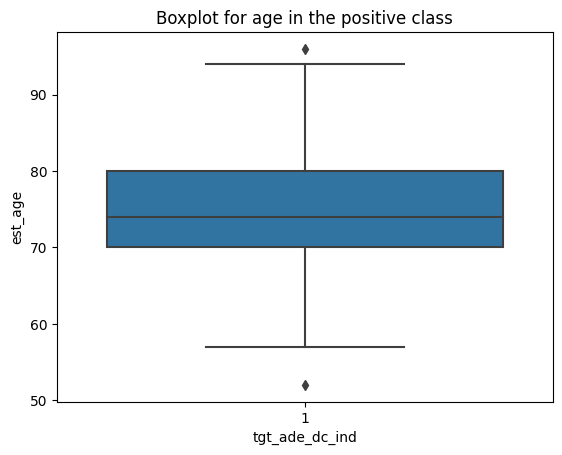

In [ ]:
#boxplot for age in the positive class
ax, fig = plt.subplots()
sns.boxplot(positive_class, y=positive_class['est_age'], x=positive_class['tgt_ade_dc_ind'])

plt.title('Boxplot for age in the positive class')

In [ ]:
negative_class['est_age'].describe()

count    1033.000000
mean       73.667957
std         8.587957
min        38.000000
25%        68.000000
50%        73.000000
75%        80.000000
max        95.000000
Name: est_age, dtype: float64

Text(0.5, 1.0, 'Boxplot for age in the negative class')

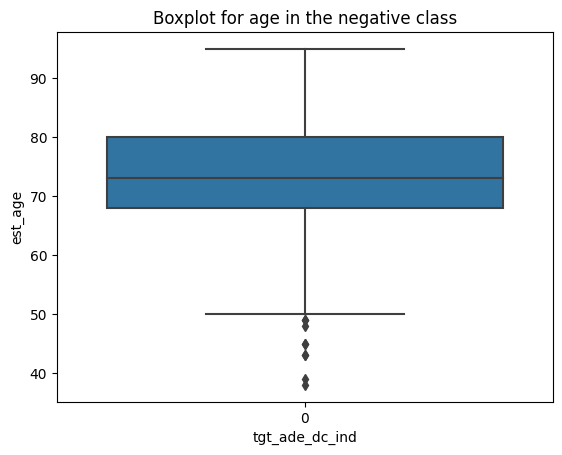

In [ ]:
#boxplot for age in the positive class
ax, fig = plt.subplots()
sns.boxplot(negative_class, y=negative_class['est_age'], x=negative_class['tgt_ade_dc_ind'])

plt.title('Boxplot for age in the negative class')

We an see that the distribution of ages in both positive and negative classes is approximately the same, with the mean of the positive class distribution being slightly higher than that of the negative class distribution.

#### **5.1.4: How does sex differ in both classes?**

In [ ]:
positive_class['sex_cd'].value_counts()

F    86
M    31
Name: sex_cd, dtype: int64

In [ ]:
positive_class['sex_cd'].value_counts(normalize=True)

F    0.735043
M    0.264957
Name: sex_cd, dtype: float64

In [ ]:
negative_class['sex_cd'].value_counts()

F    812
M    303
Name: sex_cd, dtype: int64

In [ ]:
negative_class['sex_cd'].value_counts(normalize=True)

F    0.728251
M    0.271749
Name: sex_cd, dtype: float64

We can see that in both classes, **there are more females than there are males**.

#### **5.1.5: Does disability affect both classes?**

In [ ]:
target_train[target_train['tgt_ade_dc_ind']==1]['cms_disabled_ind'].value_counts(normalize=True)

0.0    0.844828
1.0    0.155172
Name: cms_disabled_ind, dtype: float64

In [ ]:
target_train[target_train['tgt_ade_dc_ind']==0]['cms_disabled_ind'].value_counts(normalize=True)

0.0    0.853824
1.0    0.146176
Name: cms_disabled_ind, dtype: float64

Let us ask a different question. Conditional on the class where the person is disabled, how many of them have a positive class compared to a negative class?

In [ ]:
target_train[target_train['cms_disabled_ind']==1]['tgt_ade_dc_ind'].value_counts()

0    151
1     18
Name: tgt_ade_dc_ind, dtype: int64

We can see not all disabled people discontinue from treatment. There are some disabled people who have been labelled as 0. Let us take it a step further and see if those patients have indeed recovered or discontinued for some reason. Since this requires a column that we have not discussed yet, we will leave this question till later.

### **5.2. Medclms_train file**

Let us take a look at the file for the medical claims.

In [ ]:
#upload the medclms_train file
uploaded = files.upload()

Saving medclms_train.csv to medclms_train (1).csv


In [ ]:
# Identify the file name
file_name = list(uploaded.keys())[0]
file_name

'medclms_train (1).csv'

In [ ]:
#read it in pandas
medclms_train = pd.read_csv(file_name)
medclms_train.head()

,therapy_id,medclm_key,clm_unique_key,primary_diag_cd,visit_date,diag_cd2,diag_cd3,diag_cd4,diag_cd5,diag_cd6,...,hedis_pot,clm_type,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis
0,1066310426-TAGRISSO-1,35908472910,649143000473431803,I70292,2019-09-10T00:00:00.000Z,I771,I739,R9431,Z7982,Z79899,...,Other,med,0,0,0,0,0,0,0,0
1,1094522162-TAGRISSO-1,37189420103,934834000476811903,J9601,2020-08-21T00:00:00.000Z,J910,NaN,NaN,NaN,NaN,...,Other,med,0,0,0,0,0,0,0,0
2,1104741185-TAGRISSO-1,37128499255,748244100476652103,E785,2020-07-14T00:00:00.000Z,I10,J324,NaN,NaN,NaN,...,Other,med,0,0,0,0,0,0,0,0
3,1012749208-TAGRISSO-1,36269844999,589034000474672103,C3492,2020-02-04T00:00:00.000Z,I825Z9,T83518A,N390,J942,J910,...,Other,med,0,0,0,0,0,0,0,0
4,1000110916-TAGRISSO-1,36448002258,663113000474981803,C3490,2020-03-05T00:00:00.000Z,NaN,NaN,NaN,NaN,NaN,...,Outpatient,med,0,0,0,0,0,0,0,0


In [ ]:
#Let us print the explanation for each column like we did with the target_train file
for i in medclms_train.columns:
  try:
    print(f'{i} : {explain_field(i)}')
  except IndexError:
    pass

therapy_id : therapy identifier - concatenation of sdr_person_id, drug name, and therapy number
medclm_key : indicator key for a medical claim
clm_unique_key : a unique indicator key for a medical claim
primary_diag_cd : The primary diagnosis code for this claim in the ICD-10 format. Lookup available online. 
visit_date : The date of the medical visit
process_date : Date that this claim was processed
reversal_ind : Indicates whether this claim is a reversal
pot : place of treatment for this claim
util_cat : Combination of admit_type and pot for use in creating utilization categories
clm_type : Indicates if this claim is an rx claim or a med claim
ade_diagnosis : Indicates if the diagnosis codes in this claim report an adverse drug event (ADE)
seizure_diagnosis : Indicates if the diagnosis codes in this claim report seizures
pain_diagnosis : Indicates if the diagnosis codes in this claim report pain
fatigue_diagnosis : Indicates if the diagnosis codes in this claim report fatigue
nausea

#### **5.2.1. How many unique identifiers are there in medclms_train?**

In [ ]:
medclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100159 entries, 0 to 100158
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   therapy_id               100159 non-null  object
 1   medclm_key               100159 non-null  int64 
 2   clm_unique_key           100159 non-null  int64 
 3   primary_diag_cd          100159 non-null  object
 4   visit_date               100159 non-null  object
 5   diag_cd2                 76029 non-null   object
 6   diag_cd3                 58801 non-null   object
 7   diag_cd4                 47615 non-null   object
 8   diag_cd5                 38273 non-null   object
 9   diag_cd6                 32788 non-null   object
 10  diag_cd7                 27686 non-null   object
 11  diag_cd8                 24202 non-null   object
 12  diag_cd9                 21315 non-null   object
 13  process_date             100159 non-null  object
 14  reversal_ind        

We can see that there are 100159 claims! This is much greater than the 1232 obtained earlier. The reason is that one patient might have multiple claims.

#### **5.2.2 How many unique therapy ids do we have in medclms_train?**

In [ ]:
len(medclms_train['therapy_id'].unique())

536

We can see that all the claims in medclms_train correspond to 536 unique patients. This makes sense and we can use this information along with the information from target_train to include more data for model development. However, we have to do some preprocessing first. More specifically, we have to calculate metrics which we think are important predictors of a patient discontinuing from treatment. Let us see how we do that in section 6.2.

### **5.3. rxclms_train file**

Let us explore our third and final dataset, rxclms_train_file.

What is the **difference between rxclms and medclms** (short for rx claims and med claims)?

- **RX Claim (Prescription Claim)**:
  - **Purpose**:  An RX claim, short for prescription claim, is a type of healthcare claim that is related to the purchase or reimbursement of prescription medications.
  - **Content**: It includes information about the prescription drug, such as the drug name, dosage, quantity, and the prescribing healthcare provider's information.
  - **Processing**:  RX claims are typically processed by pharmacy benefit managers (PBMs) or pharmacy insurance plans. These claims are submitted by pharmacies to seek reimbursement for prescription drugs dispensed to patients.
  - **Examples**: Examples of RX claims include claims for medications you pick up at a local pharmacy, including both brand-name and generic drugs.

- **Med Claims (Medical Claims)**:
  - **Purpose**:  A med claim, short for medical claim, is a type of healthcare claim that relates to medical services provided by healthcare providers, such as doctors, hospitals, clinics, and other medical facilities.
  - **Content**: It includes information about the medical services rendered, such as diagnosis, treatments, procedures, lab tests, and other healthcare services. It also includes patient information.
  - **Processing**: Med claims are typically processed by health insurance companies or healthcare payers. These claims are submitted by healthcare providers to seek reimbursement for the medical services they have provided to patients.
  - **Examples**: Examples of med claims include claims for doctor's visits, surgeries, hospital stays, laboratory tests, X-rays, and other medical services.

In [ ]:
#upload the rxclms_train file
uploaded = files.upload()

Saving rxclms_train.csv to rxclms_train (1).csv


In [ ]:
# Identify the file name
file_name = list(uploaded.keys())[0]
file_name

'rxclms_train (1).csv'

In [ ]:
#read it in pandas
rxclms_train = pd.read_csv(file_name)
rxclms_train.head()

,therapy_id,document_key,ndc_id,service_date,process_date,pay_day_supply_cnt,rx_cost,tot_drug_cost_accum_amt,reversal_ind,mail_order_ind,...,hum_drug_class_desc,strength_meas,metric_strength,specialty_ind,clm_type,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind
0,1009508044-TAGRISSO-1,A184611654291011,169266015,2018-03-02T00:00:00.000Z,2019-12-04T00:00:00.000Z,30,919.78,2830.22,N,N,...,DIABETES,UNIT/ML,100.0,NONSPCL,rx,0,0,0,0,0
1,1023838279-TAGRISSO-1,A184877988141011,69097022416,2018-03-28T00:00:00.000Z,2020-03-13T00:00:00.000Z,28,5.00,1138.66,N,N,...,OSTEOPOROSIS,MG,70.0,NONSPCL,rx,0,0,0,0,0
2,1023838279-TAGRISSO-1,A185952462961011,60505257908,2018-07-14T00:00:00.000Z,2020-03-13T00:00:00.000Z,30,7.30,2693.11,N,N,...,CHOLESTEROL,MG,20.0,NONSPCL,rx,0,0,0,0,0
3,1023838279-TAGRISSO-1,A186219930881011,65862057290,2018-08-09T00:00:00.000Z,2020-03-17T00:00:00.000Z,30,12.20,2718.31,N,N,...,CARDIOLOGY - HYPERTENSION AGENTS,MG,160.0,NONSPCL,rx,0,0,0,0,0
4,1071647492-TAGRISSO-1,A194013465121011,16252060144,2019-01-01T00:00:00.000Z,2020-03-03T00:00:00.000Z,90,9.90,0.00,N,Y,...,OSTEOPOROSIS,MG,70.0,NONSPCL,rx,0,0,0,0,0


In [ ]:
#Let us print the explanation for each column like we did with the target_train file
for i in rxclms_train.columns:
  try:
    print(f'{i} : {explain_field(i)}')
  except IndexError:
    pass

therapy_id : therapy identifier - concatenation of sdr_person_id, drug name, and therapy number
document_key : unique identifier for a prescription claim document
ndc_id : National Drug Code Identifier: a national/FDA identifier for a specific drug. Lookup available from several online databases.
service_date : Date of a prescription fill
process_date : Date that this claim was processed
pay_day_supply_cnt : The number of days supply of a drug
rx_cost : The cost of the prescription
tot_drug_cost_accum_amt : The cumulative cost amount for a member year-to-date
reversal_ind : Indicates whether this claim is a reversal
mail_order_ind : Indicates whether this prescription was filled with the mail-order pharmacy
generic_ind : indicates whether this drug is branded or generic
maint_ind : indicates whether this drug is a maintenance or nonmaintenence drug
gpi_drug_group_desc : Generic Product Identifier drug group description
gpi_drug_class_desc : Generic Product Identifier drug class descrip

In [ ]:
rxclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               32133 non-null  object 
 1   document_key             32133 non-null  object 
 2   ndc_id                   32133 non-null  int64  
 3   service_date             32133 non-null  object 
 4   process_date             32133 non-null  object 
 5   pay_day_supply_cnt       32133 non-null  int64  
 6   rx_cost                  32133 non-null  float64
 7   tot_drug_cost_accum_amt  32133 non-null  float64
 8   reversal_ind             32133 non-null  object 
 9   mail_order_ind           32133 non-null  object 
 10  generic_ind              32133 non-null  object 
 11  maint_ind                32133 non-null  object 
 12  gpi_drug_group_desc      30234 non-null  object 
 13  gpi_drug_class_desc      30234 non-null  object 
 14  hum_drug_class_desc   

Again, we can see that the number of rows in this dataset is 32133, much higher than the unique patients we have (1232). This is because one patient can have multiple rx claims! Let us find the unique number of rxclaims that we have.

In [ ]:
len(rxclms_train['therapy_id'].unique())

1160

There you go! We can see that the number we got here is less than 1232 patients. In fact, it covers most of the sample space compated to the medclms! Hence, it would be better if we can develop as many metrics as we think are necessary from rxclms as they would be more helpful than those provided in the medclms file since they target more patients.

We will leave this section for EDA till later. Let us go for data preprocessing and see what features or calculated fields we can extract from rxclms_train file for model development.


## **Section 6: Data Preprocessing**

In this section, we perform data preprocessing for the following purposes:

- Data Cleaning if necessary
- Calculated fields that we think are useful in Data Exploration/Data Modeling

### **6.1. Data Preprocessing for target_train**

Let us start by the target_train dataset. We are given information about the therapy start date and the therapy end date for each patient. Therefore, it is useful to calculate the difference between the end and the start date to get the **total duration of stay** for the patient.

In [ ]:
#First, change the type of dates from objects to datetimes.

target_train['therapy_start_date'] = pd.to_datetime(target_train['therapy_start_date']) #datetime64[ns,  UTC]
target_train['therapy_start_date'] = target_train['therapy_start_date'].astype('datetime64[ns]') #this is to remove UTC for the therapy start date
target_train['therapy_end_date'] = pd.to_datetime(target_train['therapy_end_date']) #datetime64[ns]

target_train.info()
#now we have the therapy start date and the therapy end date to be of datetime type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  1232 non-null   int64         
 1   therapy_id          1232 non-null   object        
 2   therapy_start_date  1232 non-null   datetime64[ns]
 3   therapy_end_date    1232 non-null   datetime64[ns]
 4   tgt_ade_dc_ind      1232 non-null   int64         
 5   race_cd             1164 non-null   float64       
 6   est_age             1149 non-null   float64       
 7   sex_cd              1232 non-null   object        
 8   cms_disabled_ind    1149 non-null   float64       
 9   cms_low_income_ind  1149 non-null   float64       
 10  duration_of_stay    1232 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 106.0+ KB


In [ ]:
  #Second, calculate the field duration by subtracting start from end for each patient.

  target_train['duration_of_stay'] = target_train['therapy_end_date'] - target_train['therapy_start_date'] #We will get a column of duration_of_stays with a timedelta[ns] type

  #we need to change the duration to an integer to be able to process it and visualize it
  #let us use a lambda function for that
  target_train['duration_of_stay'] = target_train['duration_of_stay'].apply(lambda x: x.days)

  #Now we have the duration of stay as an integer (in days) for each patient
  target_train

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,duration_of_stay
0,1005597228,1005597228-TAGRISSO-1,2020-03-11,2020-09-07,0,1.0,NaN,F,NaN,NaN,180
1,1005964858,1005964858-TAGRISSO-1,2021-08-23,2021-09-22,1,1.0,86.0,M,0.0,0.0,30
2,1007548572,1007548572-TAGRISSO-1,2022-01-17,2022-07-16,0,1.0,79.0,F,0.0,1.0,180
3,1009508044,1009508044-TAGRISSO-1,2020-01-23,2020-07-21,0,1.0,70.0,F,1.0,1.0,180
4,1028064791,1028064791-TAGRISSO-1,2021-02-23,2021-08-22,0,2.0,74.0,F,1.0,1.0,180
...,...,...,...,...,...,...,...,...,...,...,...
1227,1005265852,1005265852-TAGRISSO-1,2022-01-18,2022-05-01,1,5.0,91.0,F,0.0,0.0,103
1228,1017236720,1017236720-TAGRISSO-1,2019-09-10,2020-03-08,0,1.0,79.0,M,0.0,0.0,180
1229,1059781692,1059781692-TAGRISSO-1,2020-03-10,2020-09-06,0,4.0,81.0,F,0.0,1.0,180
1230,1106680931,1106680931-TAGRISSO-1,2021-03-01,2021-03-31,0,1.0,50.0,M,1.0,0.0,30


This leads us to the following question:

**6.1.1: What is the distribution of duration of stay of patients who discontinued therapy and reported an ADE and how does this compare to the negative class**

Text(0.5, 1.0, 'Boxplot for duration of stay in both classes')

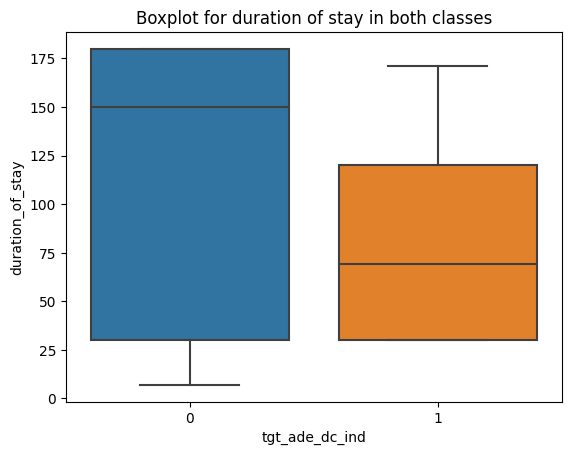

In [ ]:
#boxplot for age in the positive class
ax, fig = plt.subplots()
sns.boxplot(target_train, y=target_train['duration_of_stay'], x=target_train['tgt_ade_dc_ind'])
plt.title('Boxplot for duration of stay in both classes')

We can see from the boxplots above that the distribution for the duration of stay is skewed to the right for the negative class whereas it skewed to the left for the positive class with some outliers in both distributions. This is expected.

**6.1.2: How many patients in the negative class have a duration of stay that is less than 180?**

This is an important question because as we discussed earlier, the negative label is tricky. Some patients in the negative class have in fact discontinued treatment but they were labelled negative because there was no reported ADE before discontinuing. When we answer Q6, we know the number of patients who have discontinued treatment but were not labelled positive for some reason like failure of reporting an ADE.

In [ ]:
target_train[(target_train['duration_of_stay'] < 180) & (target_train['tgt_ade_dc_ind']==0)]

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,duration_of_stay
6,1044240562,1044240562-TAGRISSO-1,2019-08-19,2019-10-18,0,1.0,74.0,M,0.0,0.0,60
9,1101932842,1101932842-TAGRISSO-1,2022-05-06,2022-06-05,0,1.0,73.0,F,0.0,1.0,30
11,1107373430,1107373430-TAGRISSO-1,2020-07-21,2020-09-19,0,0.0,66.0,M,0.0,0.0,60
12,1107599919,1107599919-TAGRISSO-1,2021-11-01,2022-01-30,0,1.0,66.0,M,0.0,0.0,90
13,1108560006,1108560006-TAGRISSO-1,2020-09-29,2020-11-28,0,NaN,65.0,F,0.0,0.0,60
...,...,...,...,...,...,...,...,...,...,...,...
1221,1013010133,1013010133-TAGRISSO-1,2020-02-20,2020-03-21,0,1.0,92.0,F,0.0,0.0,30
1222,1014844778,1014844778-TAGRISSO-1,2021-12-14,2022-01-13,0,1.0,82.0,F,0.0,0.0,30
1226,1121703692,1121703692-TAGRISSO-1,2022-03-11,2022-04-10,0,2.0,NaN,F,NaN,NaN,30
1230,1106680931,1106680931-TAGRISSO-1,2021-03-01,2021-03-31,0,1.0,50.0,M,1.0,0.0,30


We can see that there are **581** patients who have a negative label although they have discontinued treatment before 180 days of start date! This is a significant number (around **52%** of the negative class!)

In [ ]:
581/1115

0.5210762331838565

**6.1.3: From the patients who are disabled but labelled 0, how many of them have actually continued the treatment?**

This is a follow up on question 5. We are interested to see if the disabled patients have indeed been resilient through the whole treatment or have discontinued without reporting an ADE.

In [ ]:
target_train[(target_train['cms_disabled_ind']==1) & (target_train['tgt_ade_dc_ind']==0)]
#There are 151 patients who are disabled and negatively labeled

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,duration_of_stay
3,1009508044,1009508044-TAGRISSO-1,2020-01-23,2020-07-21,0,1.0,70.0,F,1.0,1.0,180
4,1028064791,1028064791-TAGRISSO-1,2021-02-23,2021-08-22,0,2.0,74.0,F,1.0,1.0,180
5,1030317714,1030317714-TAGRISSO-1,2022-05-20,2022-11-16,0,2.0,81.0,F,1.0,1.0,180
21,1008520415,1008520415-TAGRISSO-1,2022-05-31,2022-11-27,0,2.0,83.0,F,1.0,0.0,180
38,1113018650,1113018650-TAGRISSO-1,2021-04-22,2021-10-19,0,1.0,53.0,M,1.0,1.0,180
...,...,...,...,...,...,...,...,...,...,...,...
1162,1121906962,1121906962-TAGRISSO-1,2022-05-06,2022-11-02,0,2.0,67.0,F,1.0,1.0,180
1202,1007604874,1007604874-TAGRISSO-1,2020-05-19,2020-11-15,0,1.0,78.0,F,1.0,1.0,180
1214,1118210589,1118210589-TAGRISSO-1,2022-01-26,2022-07-25,0,2.0,66.0,F,1.0,1.0,180
1220,1121210255,1121210255-TAGRISSO-1,2022-04-14,2022-10-11,0,4.0,63.0,F,1.0,1.0,180


In [ ]:
target_train[(target_train['cms_disabled_ind']==1) & (target_train['tgt_ade_dc_ind']==0)]['duration_of_stay'].value_counts()

180    95
30     20
120    11
60      8
65      2
90      2
150     2
103     2
91      1
161     1
166     1
67      1
122     1
15      1
137     1
121     1
61      1
Name: duration_of_stay, dtype: int64

We can see that **95 out of 151** (or 52%) of the disabled patients who had a negative label, actually discontinued treatment for another reason. This makes sense because generally speaking, disabled people have a lower mental toughness than others and therefore are less likely to persist with the side effects of targisso.

### **6.2. Data Preprocessing for Medclms_train File**

The file corresponding to medical claims contain important information about the **claims made by each patient** and the **type of diagnosis** for these claims. However, using all data from the file leads to overfitting. As a result, we have to be smart about what we want our models to learn by providing the right features.

In [ ]:
medclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100159 entries, 0 to 100158
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   therapy_id               100159 non-null  object        
 1   medclm_key               100159 non-null  int64         
 2   clm_unique_key           100159 non-null  int64         
 3   primary_diag_cd          100159 non-null  object        
 4   visit_date               100159 non-null  datetime64[ns]
 5   diag_cd2                 76029 non-null   object        
 6   diag_cd3                 58801 non-null   object        
 7   diag_cd4                 47615 non-null   object        
 8   diag_cd5                 38273 non-null   object        
 9   diag_cd6                 32788 non-null   object        
 10  diag_cd7                 27686 non-null   object        
 11  diag_cd8                 24202 non-null   object        
 12  diag_cd9        

In [ ]:
medclms_train.head()

,therapy_id,medclm_key,clm_unique_key,primary_diag_cd,visit_date,diag_cd2,diag_cd3,diag_cd4,diag_cd5,diag_cd6,...,hedis_pot,clm_type,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis
0,1066310426-TAGRISSO-1,35908472910,649143000473431803,I70292,2019-09-10,I771,I739,R9431,Z7982,Z79899,...,Other,med,0,0,0,0,0,0,0,0
1,1094522162-TAGRISSO-1,37189420103,934834000476811903,J9601,2020-08-21,J910,NaN,NaN,NaN,NaN,...,Other,med,0,0,0,0,0,0,0,0
2,1104741185-TAGRISSO-1,37128499255,748244100476652103,E785,2020-07-14,I10,J324,NaN,NaN,NaN,...,Other,med,0,0,0,0,0,0,0,0
3,1012749208-TAGRISSO-1,36269844999,589034000474672103,C3492,2020-02-04,I825Z9,T83518A,N390,J942,J910,...,Other,med,0,0,0,0,0,0,0,0
4,1000110916-TAGRISSO-1,36448002258,663113000474981803,C3490,2020-03-05,NaN,NaN,NaN,NaN,NaN,...,Outpatient,med,0,0,0,0,0,0,0,0


In [ ]:
#Let us print the explanation for each column like we did with the target_train file
for i in medclms_train.columns:
  try:
    print(f'{i} : {explain_field(i)}')
  except IndexError:
    pass

therapy_id : therapy identifier - concatenation of sdr_person_id, drug name, and therapy number
medclm_key : indicator key for a medical claim
clm_unique_key : a unique indicator key for a medical claim
primary_diag_cd : The primary diagnosis code for this claim in the ICD-10 format. Lookup available online. 
visit_date : The date of the medical visit
process_date : Date that this claim was processed
reversal_ind : Indicates whether this claim is a reversal
pot : place of treatment for this claim
util_cat : Combination of admit_type and pot for use in creating utilization categories
clm_type : Indicates if this claim is an rx claim or a med claim
ade_diagnosis : Indicates if the diagnosis codes in this claim report an adverse drug event (ADE)
seizure_diagnosis : Indicates if the diagnosis codes in this claim report seizures
pain_diagnosis : Indicates if the diagnosis codes in this claim report pain
fatigue_diagnosis : Indicates if the diagnosis codes in this claim report fatigue
nausea

In [ ]:
medclms_train['util_cat'].value_counts()

Outpatient          38130
IP_ACUTE             7631
Physician_Office     7116
ER                   2679
Ambulance             617
IP_SNF                285
Urgent_Care           147
IP_REHAB               71
IP_MHSA                52
IP_LTACH                3
Name: util_cat, dtype: int64

#### **6.2.1. The Number of Diagnosis for each patient.**

We not only know how many claims per patient there are, but we also have information about the type of diagnosis that is inferred from the claim, like ade_diagnosis, seizure_diagnosis, and so on. We know that these diagnosis are important predictors for treatment discontinuity. Let us sum the occurances of these diagnoses for each patient!

In [ ]:
diagnosis_count_per_patient=medclms_train.groupby(by=['therapy_id'], as_index = False).agg(
    {'ade_diagnosis':'sum',
     'seizure_diagnosis':'sum',
     'pain_diagnosis':'sum',
     'fatigue_diagnosis':'sum',
     'nausea_diagnosis':'sum',
     'hyperglycemia_diagnosis':'sum',
     'constipation_diagnosis':'sum',
     'diarrhea_diagnosis':'sum'})
diagnosis_count_per_patient


,therapy_id,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis
0,1000110916-TAGRISSO-1,8,0,0,0,7,0,1,7
1,1000207687-TAGRISSO-1,5,0,0,5,0,0,0,0
2,1000260673-TAGRISSO-1,25,0,25,0,0,0,0,0
3,1000767323-TAGRISSO-1,6,0,0,0,0,0,0,6
4,1000767683-TAGRISSO-1,66,0,0,1,65,0,0,0
...,...,...,...,...,...,...,...,...,...
531,1121093945-TAGRISSO-1,0,0,0,0,0,0,0,0
532,1121210255-TAGRISSO-1,0,0,0,0,0,0,0,0
533,1121906962-TAGRISSO-1,0,0,0,0,0,0,0,0
534,1121951424-TAGRISSO-1,0,0,0,0,0,0,0,0


### **6.2.2. The number of visits before and after therapy start date**

How can we get value from the visit date? We have discovered that the information we have about "visit_date" starts before the therapy start date. In other words, the visit date can be higher or lower than the therapy start. We wish to see how the number of visits for each patient change before and after therapy. The reason is that **we assume that if the patient is indeed suffering from side effects, the number of visits are likely to increase after therapy start date**. As a result, we will calculate the number of visits before and after therapy starts and include them in the model.

In [ ]:
#first change visit_date to datetime

medclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100159 entries, 0 to 100158
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   therapy_id               100159 non-null  object        
 1   medclm_key               100159 non-null  int64         
 2   clm_unique_key           100159 non-null  int64         
 3   primary_diag_cd          100159 non-null  object        
 4   visit_date               100159 non-null  datetime64[ns]
 5   diag_cd2                 76029 non-null   object        
 6   diag_cd3                 58801 non-null   object        
 7   diag_cd4                 47615 non-null   object        
 8   diag_cd5                 38273 non-null   object        
 9   diag_cd6                 32788 non-null   object        
 10  diag_cd7                 27686 non-null   object        
 11  diag_cd8                 24202 non-null   object        
 12  diag_cd9        

In [ ]:
medclms_train['visit_date'] = pd.to_datetime(medclms_train['visit_date']) #datetime64[ns,  UTC]
medclms_train['visit_date'] = medclms_train['visit_date'].astype('datetime64[ns]')
medclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100159 entries, 0 to 100158
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   therapy_id               100159 non-null  object        
 1   medclm_key               100159 non-null  int64         
 2   clm_unique_key           100159 non-null  int64         
 3   primary_diag_cd          100159 non-null  object        
 4   visit_date               100159 non-null  datetime64[ns]
 5   diag_cd2                 76029 non-null   object        
 6   diag_cd3                 58801 non-null   object        
 7   diag_cd4                 47615 non-null   object        
 8   diag_cd5                 38273 non-null   object        
 9   diag_cd6                 32788 non-null   object        
 10  diag_cd7                 27686 non-null   object        
 11  diag_cd8                 24202 non-null   object        
 12  diag_cd9        

In [ ]:
#Now we want to join the target_train table with the medclms_train table and calculate the duration between the therapy start date and the visit date
df1 = medclms_train[['therapy_id', 'visit_date']]
df2 = target_train[['therapy_id', 'therapy_start_date']]

df = pd.merge(df2, df1, on = 'therapy_id', how='left')

#calculate the difference in days
df['duration'] = df['visit_date'] - df['therapy_start_date']

#change to integers
df['duration'] = df['duration'].apply(lambda x: x.days)
df

#let us try to see if the number of visits change before and after the therapy date for each patient
df['before_dummy'] = df['duration'].apply(lambda x: 1 if x < 0 else 0)
df['after_dummy'] = df['duration'].apply(lambda x: 0 if x<0 else 1)

#create two columns for visits before therapy and visits after therapy
df['visits_before_therapy'] = df['duration']*df['before_dummy']*-1
df['visits_after_therapy'] = df['duration']*df['after_dummy']


#group by therapy id
num_visits = df.groupby(by='therapy_id', as_index=False).agg({'before_dummy':'sum', 'after_dummy':'sum'})

num_visits.rename(columns={'before_dummy':'num_visits_before_therapy'}, inplace = True)
num_visits.rename(columns={'after_dummy':'num_visits_after_therapy'}, inplace = True)

num_visits

,therapy_id,num_visits_before_therapy,num_visits_after_therapy
0,1000110916-TAGRISSO-1,98,26
1,1000207687-TAGRISSO-1,157,33
2,1000260673-TAGRISSO-1,83,59
3,1000389557-TAGRISSO-1,0,1
4,1000767323-TAGRISSO-1,30,35
...,...,...,...
1227,1122901791-TAGRISSO-1,0,1
1228,1122967891-TAGRISSO-1,0,1
1229,1123139543-TAGRISSO-1,0,1
1230,1123143756-TAGRISSO-1,0,1


**Note** there is no need to include the number of visits before and after start date since it has high correlation with claim frequency (discussed next)

### **6.2.3. The claim frequency before and after therapy**

Not only is it important to look at the number of visits before and after therapy, but it is also as crucial to find the claim frequency before and after therapy. For example, 3 claims in 2 days is different than 3 claims in 90 days. And so, in this section, we introduce two additional features:

- claim frequency before therapy starts: num_visits_before_therapy divided by the duration between the earliest visit and therapy start date
- claim frequenct after therapy starts: num_visits_after_therapy divided by the duration between the therapy start date and the therapy end date.



In [ ]:
#first we find the earliest visit date for each patient
earliest_visit_date = medclms_train.groupby('therapy_id', as_index=False).agg({'visit_date':'min'})
earliest_visit_date

,therapy_id,visit_date
0,1000110916-TAGRISSO-1,2019-06-20
1,1000207687-TAGRISSO-1,2018-11-17
2,1000260673-TAGRISSO-1,2021-05-08
3,1000767323-TAGRISSO-1,2021-09-07
4,1000767683-TAGRISSO-1,2019-07-03
...,...,...
531,1121093945-TAGRISSO-1,2022-03-08
532,1121210255-TAGRISSO-1,2022-07-05
533,1121906962-TAGRISSO-1,2022-04-01
534,1121951424-TAGRISSO-1,2022-05-03


In [ ]:
#now we concatentate this to the therapy start date and the duration of stay in target train
df1 = target_train[['therapy_id', 'therapy_start_date', 'duration_of_stay']]
df = pd.merge(df1, earliest_visit_date, on='therapy_id', how='left')

#Find the time between earliest visit date and therapy start
df['earliest_visit_and_therapy_start'] = df['visit_date'] - df['therapy_start_date']
df['earliest_visit_and_therapy_start'] = df['earliest_visit_and_therapy_start'].apply(lambda x: -x.days)
df

,therapy_id,therapy_start_date,duration_of_stay,visit_date,earliest_visit_and_therapy_start
0,1005597228-TAGRISSO-1,2020-03-11,180,2019-11-21,111.0
1,1005964858-TAGRISSO-1,2021-08-23,30,2021-04-05,140.0
2,1007548572-TAGRISSO-1,2022-01-17,180,2021-03-13,310.0
3,1009508044-TAGRISSO-1,2020-01-23,180,2019-06-04,233.0
4,1028064791-TAGRISSO-1,2021-02-23,180,2020-10-12,134.0
...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,2022-01-18,103,2021-09-20,120.0
1228,1017236720-TAGRISSO-1,2019-09-10,180,NaT,NaN
1229,1059781692-TAGRISSO-1,2020-03-10,180,NaT,NaN
1230,1106680931-TAGRISSO-1,2021-03-01,30,2020-11-24,97.0


In [ ]:
df_f = df[['therapy_id', 'duration_of_stay', 'earliest_visit_and_therapy_start']]
df_f.fillna(0, inplace = True)
df_f

,therapy_id,duration_of_stay,earliest_visit_and_therapy_start
0,1005597228-TAGRISSO-1,180,111.0
1,1005964858-TAGRISSO-1,30,140.0
2,1007548572-TAGRISSO-1,180,310.0
3,1009508044-TAGRISSO-1,180,233.0
4,1028064791-TAGRISSO-1,180,134.0
...,...,...,...
1227,1005265852-TAGRISSO-1,103,120.0
1228,1017236720-TAGRISSO-1,180,0.0
1229,1059781692-TAGRISSO-1,180,0.0
1230,1106680931-TAGRISSO-1,30,97.0


In [ ]:
#join to num_visits
num_visits

,therapy_id,num_visits_before_therapy,num_visits_after_therapy
0,1000110916-TAGRISSO-1,98,26
1,1000207687-TAGRISSO-1,157,33
2,1000260673-TAGRISSO-1,83,59
3,1000389557-TAGRISSO-1,0,1
4,1000767323-TAGRISSO-1,30,35
...,...,...,...
1227,1122901791-TAGRISSO-1,0,1
1228,1122967891-TAGRISSO-1,0,1
1229,1123139543-TAGRISSO-1,0,1
1230,1123143756-TAGRISSO-1,0,1


In [ ]:
claim_freq_before_after_therapy = pd.merge(num_visits, df_f, on = 'therapy_id', how = 'left')
#define the columns to be used
claim_freq_before_after_therapy['claim_freq_before_therapy'] = claim_freq_before_after_therapy['num_visits_before_therapy']/claim_freq_before_after_therapy['earliest_visit_and_therapy_start']
claim_freq_before_after_therapy['claim_freq_after_therapy'] = claim_freq_before_after_therapy['num_visits_after_therapy']/claim_freq_before_after_therapy['duration_of_stay']

claim_freq_before_after_therapy=claim_freq_before_after_therapy[['therapy_id', 'claim_freq_before_therapy', 'claim_freq_after_therapy']]
claim_freq_before_after_therapy

,therapy_id,claim_freq_before_therapy,claim_freq_after_therapy
0,1000110916-TAGRISSO-1,0.327759,0.288889
1,1000207687-TAGRISSO-1,0.492163,1.100000
2,1000260673-TAGRISSO-1,1.037500,0.491667
3,1000389557-TAGRISSO-1,NaN,0.005556
4,1000767323-TAGRISSO-1,0.247934,0.388889
...,...,...,...
1227,1122901791-TAGRISSO-1,NaN,0.033333
1228,1122967891-TAGRISSO-1,NaN,0.015385
1229,1123139543-TAGRISSO-1,NaN,0.015625
1230,1123143756-TAGRISSO-1,NaN,0.005556


### **6.2.4. The Visit Time Ratio**

The visit time ratio is a metric we argue is highly predictive of the outocome. It is defined as the ratio of (time between therapy start date and the earliest medical claim visit date after therapy start date) divided by (time between therapy start date and the latest medical claim visit date before therapy start date)

In [ ]:
df1 = medclms_train[['therapy_id', 'visit_date']]
df2 = target_train[['therapy_id', 'therapy_start_date']]

df = pd.merge(df2, df1, on = 'therapy_id', how='left')

#calculate the difference in days
df['duration'] = df['visit_date'] - df['therapy_start_date']

#change to integers
df['duration'] = df['duration'].apply(lambda x: x.days)

#filter on positive durations
df = df[df['duration']>=0]

#group by minimum
earliest_to_visit = df.groupby('therapy_id', as_index = False).agg({'duration':'min'})
earliest_to_visit.rename(columns = {'duration':'earliest_to_visit_days'}, inplace = True)
earliest_to_visit

,therapy_id,earliest_to_visit_days
0,1000110916-TAGRISSO-1,4.0
1,1000207687-TAGRISSO-1,5.0
2,1000260673-TAGRISSO-1,15.0
3,1000767323-TAGRISSO-1,29.0
4,1000767683-TAGRISSO-1,16.0
...,...,...
515,1121093945-TAGRISSO-1,9.0
516,1121210255-TAGRISSO-1,82.0
517,1121906962-TAGRISSO-1,20.0
518,1121951424-TAGRISSO-1,0.0


In [ ]:
#The above calculates numerator of the ratio, we still need to calculate the denomenator

df1 = medclms_train[['therapy_id', 'visit_date']]
df2 = target_train[['therapy_id', 'therapy_start_date']]

df = pd.merge(df2, df1, on = 'therapy_id', how='left')

#calculate the difference in days
df['duration'] = df['visit_date'] - df['therapy_start_date']

#change to integers
df['duration'] = df['duration'].apply(lambda x: x.days)

#find negative durations
df=df[df['duration']<0]

#groupby max
#group by minimum
latest_to_visit = df.groupby('therapy_id', as_index = False).agg({'duration':'max'})
latest_to_visit.rename(columns = {'duration':'latest_to_visit'}, inplace = True)
latest_to_visit['latest_to_visit']=latest_to_visit['latest_to_visit'].apply(lambda x: -x)
latest_to_visit

,therapy_id,latest_to_visit
0,1000110916-TAGRISSO-1,1.0
1,1000207687-TAGRISSO-1,15.0
2,1000260673-TAGRISSO-1,11.0
3,1000767323-TAGRISSO-1,1.0
4,1000767683-TAGRISSO-1,3.0
...,...,...
506,1118411541-TAGRISSO-1,5.0
507,1118630665-TAGRISSO-1,1.0
508,1119101215-TAGRISSO-1,17.0
509,1121093945-TAGRISSO-1,6.0


In [ ]:
#now find the ratio
df = pd.merge(earliest_to_visit, latest_to_visit, on='therapy_id', how = 'outer')
df

,therapy_id,earliest_to_visit_days,latest_to_visit
0,1000110916-TAGRISSO-1,4.0,1.0
1,1000207687-TAGRISSO-1,5.0,15.0
2,1000260673-TAGRISSO-1,15.0,11.0
3,1000767323-TAGRISSO-1,29.0,1.0
4,1000767683-TAGRISSO-1,16.0,3.0
...,...,...,...
531,1100138510-TAGRISSO-1,NaN,6.0
532,1104838618-TAGRISSO-1,NaN,4.0
533,1106680931-TAGRISSO-1,NaN,3.0
534,1108043180-TAGRISSO-1,NaN,2.0


In [ ]:
#for nulls in earliest_to_visit_days, assume a 180 days
df['earliest_to_visit_days']=df['earliest_to_visit_days'].fillna(180)
#for nulls in latest to visit, also fill nulls with 180
df['latest_to_visit']=df['latest_to_visit'].fillna(180)

df['visit_time_ratio'] = df['earliest_to_visit_days']/df['latest_to_visit']
visit_time_ratio=df[['therapy_id', 'visit_time_ratio']]
visit_time_ratio

,therapy_id,visit_time_ratio
0,1000110916-TAGRISSO-1,4.000000
1,1000207687-TAGRISSO-1,0.333333
2,1000260673-TAGRISSO-1,1.363636
3,1000767323-TAGRISSO-1,29.000000
4,1000767683-TAGRISSO-1,5.333333
...,...,...
531,1100138510-TAGRISSO-1,30.000000
532,1104838618-TAGRISSO-1,45.000000
533,1106680931-TAGRISSO-1,60.000000
534,1108043180-TAGRISSO-1,90.000000


#### **6.2.5. Concatenating all the results together**

Let us concatenate all the results together.



In [ ]:
feature_selection_from_medclms=medclms_train.groupby(by=['therapy_id'], as_index = False).agg(
    {#'clm_unique_key': 'count', drop this because we broke it down into before and after therapy
     'ade_diagnosis':'sum',
     'seizure_diagnosis':'sum',
     'pain_diagnosis':'sum',
     'fatigue_diagnosis':'sum',
     'nausea_diagnosis':'sum',
     'hyperglycemia_diagnosis':'sum',
     'constipation_diagnosis':'sum',
     'diarrhea_diagnosis':'sum'})

#rename clm_unique_key column to claim_count
feature_selection_from_medclms.rename(columns={'clm_unique_key':'claim_count'}, inplace = True)

#feature_selection_from_medclms = pd.merge(num_visits, feature_selection_from_medclms, on = 'therapy_id', how = 'left')
#no need to include num_visits as we are already including the claim_freq which is highly correlated with it.

feature_selection_from_medclms = pd.merge(claim_freq_before_after_therapy, feature_selection_from_medclms, on = 'therapy_id', how = 'left')
feature_selection_from_medclms = pd.merge(feature_selection_from_medclms, earliest_to_visit, on = 'therapy_id', how = 'left') #visit_time_ratio hurts predictions

#fill all the rest with nulls
feature_selection_from_medclms.fillna(0, inplace = True)

feature_selection_from_medclms

,therapy_id,claim_freq_before_therapy,claim_freq_after_therapy,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis,earliest_to_visit_days
0,1000110916-TAGRISSO-1,0.327759,0.288889,8.0,0.0,0.0,0.0,7.0,0.0,1.0,7.0,4.0
1,1000207687-TAGRISSO-1,0.492163,1.100000,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0
2,1000260673-TAGRISSO-1,1.037500,0.491667,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,15.0
3,1000389557-TAGRISSO-1,0.000000,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000767323-TAGRISSO-1,0.247934,0.388889,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1122901791-TAGRISSO-1,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1228,1122967891-TAGRISSO-1,0.000000,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1229,1123139543-TAGRISSO-1,0.000000,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1230,1123143756-TAGRISSO-1,0.000000,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use the dataframe above to join it to the target_train file for model development.

### **6.3. Data Preprocessing for rxclms_train**

The rxclms train file contains important information about prescription claims, which we can use to calculate fields and extract features that we think are causal to the patient discontinuing the treatment. We next discuss the metrics that we think are valuable in including in the model.

In [ ]:
rxclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               32133 non-null  object 
 1   document_key             32133 non-null  object 
 2   ndc_id                   32133 non-null  int64  
 3   service_date             32133 non-null  object 
 4   process_date             32133 non-null  object 
 5   pay_day_supply_cnt       32133 non-null  int64  
 6   rx_cost                  32133 non-null  float64
 7   tot_drug_cost_accum_amt  32133 non-null  float64
 8   reversal_ind             32133 non-null  object 
 9   mail_order_ind           32133 non-null  object 
 10  generic_ind              32133 non-null  object 
 11  maint_ind                32133 non-null  object 
 12  gpi_drug_group_desc      30234 non-null  object 
 13  gpi_drug_class_desc      30234 non-null  object 
 14  hum_drug_class_desc   

In [ ]:
rxclms_train.head()

,therapy_id,document_key,ndc_id,service_date,process_date,pay_day_supply_cnt,rx_cost,tot_drug_cost_accum_amt,reversal_ind,mail_order_ind,...,hum_drug_class_desc,strength_meas,metric_strength,specialty_ind,clm_type,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind
0,1009508044-TAGRISSO-1,A184611654291011,169266015,2018-03-02T00:00:00.000Z,2019-12-04T00:00:00.000Z,30,919.78,2830.22,N,N,...,DIABETES,UNIT/ML,100.0,NONSPCL,rx,0,0,0,0,0
1,1023838279-TAGRISSO-1,A184877988141011,69097022416,2018-03-28T00:00:00.000Z,2020-03-13T00:00:00.000Z,28,5.00,1138.66,N,N,...,OSTEOPOROSIS,MG,70.0,NONSPCL,rx,0,0,0,0,0
2,1023838279-TAGRISSO-1,A185952462961011,60505257908,2018-07-14T00:00:00.000Z,2020-03-13T00:00:00.000Z,30,7.30,2693.11,N,N,...,CHOLESTEROL,MG,20.0,NONSPCL,rx,0,0,0,0,0
3,1023838279-TAGRISSO-1,A186219930881011,65862057290,2018-08-09T00:00:00.000Z,2020-03-17T00:00:00.000Z,30,12.20,2718.31,N,N,...,CARDIOLOGY - HYPERTENSION AGENTS,MG,160.0,NONSPCL,rx,0,0,0,0,0
4,1071647492-TAGRISSO-1,A194013465121011,16252060144,2019-01-01T00:00:00.000Z,2020-03-03T00:00:00.000Z,90,9.90,0.00,N,Y,...,OSTEOPOROSIS,MG,70.0,NONSPCL,rx,0,0,0,0,0


In [ ]:
#Let us print the explanation for each column like we did with the target_train file
for i in rxclms_train.columns:
  try:
    print(f'{i} : {explain_field(i)}')
  except IndexError:
    pass

therapy_id : therapy identifier - concatenation of sdr_person_id, drug name, and therapy number
document_key : unique identifier for a prescription claim document
ndc_id : National Drug Code Identifier: a national/FDA identifier for a specific drug. Lookup available from several online databases.
service_date : Date of a prescription fill
process_date : Date that this claim was processed
pay_day_supply_cnt : The number of days supply of a drug
rx_cost : The cost of the prescription
tot_drug_cost_accum_amt : The cumulative cost amount for a member year-to-date
reversal_ind : Indicates whether this claim is a reversal
mail_order_ind : Indicates whether this prescription was filled with the mail-order pharmacy
generic_ind : indicates whether this drug is branded or generic
maint_ind : indicates whether this drug is a maintenance or nonmaintenence drug
gpi_drug_group_desc : Generic Product Identifier drug group description
gpi_drug_class_desc : Generic Product Identifier drug class descrip

#### **6.3.1 The Number of Unique Classes of hum_drug_class_desc**

We argue that the Humana Drug Class Description gives a brief description of the drug prescribed. The only problem with this is the number of features (72 columns after one-hot encoding). **Should we use it or it is sufficient that we use ~_treat_ind columns instead?** This is something to be tested later on.

In [ ]:
rxclms_train['hum_drug_class_desc'].value_counts()

CHEMOTHERAPY                        5078
CARDIOLOGY - HYPERTENSION AGENTS    4016
PAIN MGMT - NARCOTIC ANALGESICS     1708
ANTI-INFECTIVES                     1556
CHOLESTEROL                         1404
                                    ... 
STEROIDS - ANDROGENS                   3
HORMONE SUPPRESANT AGENTS              3
IMMUNE GLOBULIN AGENTS                 2
OPHTHALMOLOGY - AMD/DME AGENTS         1
PAIN MGMT - VISCOSUPPLEMENTS           1
Name: hum_drug_class_desc, Length: 72, dtype: int64

In [ ]:
#Let us try grouping therapy_id by the count of hum_drug_class_desc
count_distinct_hum_drug_class = rxclms_train.groupby(by=['therapy_id'], as_index=False).agg({
    'hum_drug_class_desc':'nunique'
})

count_distinct_hum_drug_class
#The use of nunique gives us the count distinct of the hum_drug_class_desc class

,therapy_id,hum_drug_class_desc
0,1000110916-TAGRISSO-1,15
1,1000207687-TAGRISSO-1,11
2,1000260673-TAGRISSO-1,12
3,1000389557-TAGRISSO-1,6
4,1000767323-TAGRISSO-1,5
...,...,...
1155,1122883945-TAGRISSO-1,1
1156,1122901791-TAGRISSO-1,2
1157,1122967891-TAGRISSO-1,8
1158,1123139543-TAGRISSO-1,5


#### **6.3.2 The Count of the hum_drug_class_desc**

We argue that the actual count of occurances of the Humana Drug Class Description is as important as the number of unique counts. The higher the number of Humana Drug classes the patient has, the more likely he is suffering from side effects.  

In [ ]:
count_hum_drug_class = rxclms_train.groupby(by=['therapy_id'], as_index=False).agg({
    'hum_drug_class_desc':'count'
})

count_hum_drug_class

,therapy_id,hum_drug_class_desc
0,1000110916-TAGRISSO-1,39
1,1000207687-TAGRISSO-1,18
2,1000260673-TAGRISSO-1,32
3,1000389557-TAGRISSO-1,21
4,1000767323-TAGRISSO-1,13
...,...,...
1155,1122883945-TAGRISSO-1,1
1156,1122901791-TAGRISSO-1,3
1157,1122967891-TAGRISSO-1,10
1158,1123139543-TAGRISSO-1,7


### **6.3.3 The sum of _treat_ind columns grouped by therapy_id**

The last five columns are important predictors of whether the patient is going to stop the treatment or not, as they contain information specific to Targisso and its side effects.

In [ ]:
sum_treat_ind = rxclms_train.groupby(by=['therapy_id'], as_index=False).agg({
    'ddi_ind':'sum',
    'anticoag_ind': 'sum',
    'diarrhea_treat_ind':'sum',
    'nausea_treat_ind':'sum',
    'seizure_treat_ind':'sum'
})

sum_treat_ind

,therapy_id,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind
0,1000110916-TAGRISSO-1,0,3,0,0,0
1,1000207687-TAGRISSO-1,2,1,0,0,0
2,1000260673-TAGRISSO-1,3,0,0,1,0
3,1000389557-TAGRISSO-1,0,0,0,2,0
4,1000767323-TAGRISSO-1,0,0,0,0,0
...,...,...,...,...,...,...
1155,1122883945-TAGRISSO-1,0,0,0,0,0
1156,1122901791-TAGRISSO-1,0,0,0,0,0
1157,1122967891-TAGRISSO-1,0,1,0,0,1
1158,1123139543-TAGRISSO-1,0,0,0,0,0


**NOTE**: There is a value in the strength metric of the drug as well as the unit of measurement. However, we shall find a way to standardize these numbers as there a lot of units of measurements and they are not on the same scale! For now, let us exclude these features in the model development, we can come back later to this and find a way to deal with it.

### **6.3.4 The difference in the number of services requested by the patient before and after therapy starts**

Like we did before for the visit_date in the medclms_train file, we will calculate the number of services requested by the patient before and after therapy and include them in the model. Combined with what we did earlier for visits before and after therapy, we think that the model will learn better.

In [ ]:
#change the service_date column to the required format
rxclms_train['service_date'] = pd.to_datetime(rxclms_train['service_date']) #datetime64[ns,  UTC]
rxclms_train['service_date'] = rxclms_train['service_date'].astype('datetime64[ns]')
rxclms_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   therapy_id               32133 non-null  object        
 1   document_key             32133 non-null  object        
 2   ndc_id                   32133 non-null  int64         
 3   service_date             32133 non-null  datetime64[ns]
 4   process_date             32133 non-null  object        
 5   pay_day_supply_cnt       32133 non-null  int64         
 6   rx_cost                  32133 non-null  float64       
 7   tot_drug_cost_accum_amt  32133 non-null  float64       
 8   reversal_ind             32133 non-null  object        
 9   mail_order_ind           32133 non-null  object        
 10  generic_ind              32133 non-null  object        
 11  maint_ind                32133 non-null  object        
 12  gpi_drug_group_desc      30234 n

In [ ]:

#Now we want to join the target_train table with the medclms_train table and calculate the duration between the therapy start date and the visit date
df1 = rxclms_train[['therapy_id', 'service_date']]
df2 = target_train[['therapy_id', 'therapy_start_date']]

df = pd.merge(df2, df1, on = 'therapy_id', how='left')

#calculate the difference in days
df['duration'] = df['service_date'] - df['therapy_start_date']

#change to integers
df['duration'] = df['duration'].apply(lambda x: x.days)

#let us try to see if the number of visits change before and after the therapy date for each patient
df['before_dummy'] = df['duration'].apply(lambda x: 1 if x < 0 else 0)
df['after_dummy'] = df['duration'].apply(lambda x: 0 if x<0 else 1)

#create two columns for visits before therapy and visits after therapy
df['services_before_therapy'] = df['duration']*df['before_dummy']*-1
df['services_after_therapy'] = df['duration']*df['after_dummy']


#group by therapy id
num_services = df.groupby(by='therapy_id', as_index=False).agg({'before_dummy':'sum', 'after_dummy':'sum'})

num_services.rename(columns={'before_dummy':'num_services_before_therapy'}, inplace = True)
num_services.rename(columns={'after_dummy':'num_services_after_therapy'}, inplace = True)

num_services

,therapy_id,num_services_before_therapy,num_services_after_therapy
0,1000110916-TAGRISSO-1,21,21
1,1000207687-TAGRISSO-1,21,7
2,1000260673-TAGRISSO-1,14,18
3,1000389557-TAGRISSO-1,11,10
4,1000767323-TAGRISSO-1,5,8
...,...,...,...
1227,1122901791-TAGRISSO-1,2,1
1228,1122967891-TAGRISSO-1,0,10
1229,1123139543-TAGRISSO-1,0,7
1230,1123143756-TAGRISSO-1,0,37


### **6.3.4 Cost of Prescription before and after therapy start date**

Since insurance does not cover the full insurance, patients might find it economically challenging to buy certain prescription drugs. As a result, we argue that the higher the cost of the prescription drug, the more likely it is that the patient is going to discontinue the treatment. Let us include them in the model!

Let us include two columns: Instead of including the total cost of prescription before and after therapy. Let us normalize it by the time. If before therapy, divide it by the duration between the earliest service date and the therapy start date. If the service is after therapy, divide it by the duration of stay



In [ ]:
cost_data = rxclms_train[['therapy_id', 'rx_cost', 'service_date']]

#groupby therapy id and service date to find the rx_cost for each date
cost_data = cost_data.groupby(['therapy_id', 'service_date'], as_index=False).agg({'rx_cost':'sum'})

#concatenate with therapy start and therapy end date
df = pd.merge(cost_data, target_train[['therapy_id', 'therapy_start_date', 'therapy_end_date']], on = 'therapy_id', how = 'left')
df['time_between_therapy_start_and_service']=df['therapy_start_date']-df['service_date']
df['time_between_therapy_end_and_service'] = df['therapy_end_date']-df['service_date']

#change to numbers
df['time_between_therapy_start_and_service']=df['time_between_therapy_start_and_service'].apply(lambda x: x.days)
df['time_between_therapy_end_and_service'] = df['time_between_therapy_end_and_service'].apply(lambda x: x.days)

#include dummies for whether the service is before or after the therapy start date
df['dummy_therapy_start_after_service_date']=df['time_between_therapy_start_and_service'].apply(lambda x: 1 if x >= 0 else -1)

df['cost'] = df['rx_cost']*df['dummy_therapy_start_after_service_date']

#finalize the columns
df['cost_service_before_therapy_starts']=df['cost'].apply(lambda x: x if x>=0 else 0)
df['cost_service_after_therapy_starts']=df['cost'].apply(lambda x: -x if x<0 else 0)

#group by
cost_data = df.groupby(by='therapy_id', as_index=False).agg({'cost_service_before_therapy_starts':'mean', 'cost_service_after_therapy_starts':'mean'})
cost_data

,therapy_id,cost_service_before_therapy_starts,cost_service_after_therapy_starts
0,1000110916-TAGRISSO-1,783.709231,1279.962692
1,1000207687-TAGRISSO-1,1081.221875,7.612500
2,1000260673-TAGRISSO-1,923.165000,2840.722222
3,1000389557-TAGRISSO-1,1023.140000,6164.430625
4,1000767323-TAGRISSO-1,1359.531667,2716.907500
...,...,...,...
1155,1122883945-TAGRISSO-1,0.000000,186.060000
1156,1122901791-TAGRISSO-1,7559.670000,0.000000
1157,1122967891-TAGRISSO-1,2506.355000,2887.178333
1158,1123139543-TAGRISSO-1,0.000000,5118.790000


In [ ]:
#now that we have the cost data, what we should do next is normalize it by dividing by the duration between service date and therapy start date (if service is before
#therapy) or duration of stay (if service is after therapy)

df1 = target_train[['therapy_id', 'therapy_start_date', 'duration_of_stay']]
df2 = rxclms_train.groupby('therapy_id', as_index = False).agg({'service_date':'min'})
df3 = pd.merge(df1,df2,on='therapy_id', how = 'left')
df4 = pd.merge(df3, cost_data, on='therapy_id',how='left')
df4['earliest_service_duration_from_therapy'] = (df4['service_date']-df4['therapy_start_date']).apply(lambda x: -x.days)
#not to have infinity later on, replace 0s with 1s. In other words, assume that the patient's service date is 1 day before the actual service date
#if the service date is at the time the therapy starts
df4['earliest_service_duration_from_therapy'].replace(0, 1, inplace = True)

df4['average_cost_before_therapy']=df4['cost_service_before_therapy_starts']/df4['earliest_service_duration_from_therapy']
df4['average_cost_after_therapy']=df4['cost_service_after_therapy_starts']/df4['duration_of_stay']
avg_cost_before_after_therapy=df4[['therapy_id', 'average_cost_before_therapy', 'average_cost_after_therapy']]
avg_cost_before_after_therapy

,therapy_id,average_cost_before_therapy,average_cost_after_therapy
0,1005597228-TAGRISSO-1,14.920208,35.373253
1,1005964858-TAGRISSO-1,10.432928,0.064431
2,1007548572-TAGRISSO-1,1.825440,5.494327
3,1009508044-TAGRISSO-1,0.643106,7.200468
4,1028064791-TAGRISSO-1,4.489544,14.825175
...,...,...,...
1227,1005265852-TAGRISSO-1,6.043034,10.419659
1228,1017236720-TAGRISSO-1,4.967081,16.924605
1229,1059781692-TAGRISSO-1,12.213479,20.914590
1230,1106680931-TAGRISSO-1,38.289205,0.104267


So for the model, append the dataframe above instead of appending the cost data.

### **6.3.5. Accounting for the actual Humana Drug Class**

Earlier, we said that we include only the count of the humana drug classes. Let us see if adding the actual classes benefit the model or confuses it.

In [ ]:
rxclms_train['hum_drug_class_desc'].unique()

array(['DIABETES', 'OSTEOPOROSIS', 'CHOLESTEROL',
       'CARDIOLOGY - HYPERTENSION AGENTS', 'STEROIDS',
       'MENTAL HEALTH - ANXIETY AGENTS',
       'PAIN MGMT - NARCOTIC ANALGESICS', 'ANTICONVULSANTS',
       'GASTROINTESTINAL DISEASE', 'CHEMOTHERAPY', 'COUGH/ COLD/ ALLERGY',
       'CARDIOLOGY - BLOOD THINNERS', 'ANTI-INFECTIVES',
       'NUTRITIONAL/ VITAMIN', 'MENTAL HEALTH - ANTI-DEMENTIA AGENTS',
       'GASTROINTESTINAL DISEASE - GERD', nan, 'PAIN MGMT - NSAID AGENTS',
       'MENTAL HEALTH - DEPRESSION AGENTS',
       'PAIN MGMT - MUSCLE RELAXANTS', 'DERMATOLOGY',
       'OPHTHALMOLOGY - STEROID AGENTS',
       'CARDIOLOGY - ANTIPLATELET AGENTS', 'EAR/MOUTH/THROAT', 'THYROID',
       'ENDOCRINOLOGY - GOUT', 'RESPIRATORY - ASTHMA',
       'RESPIRATORY - COPD', 'OPHTHALMOLOGY - ALLERGY AGENTS',
       'MENTAL HEALTH - ANTIPSYCHOTIC AGENTS', 'DIABETIC SUPPLIES',
       'GASTROINTESTINAL DISEASE - CONSTIPATION', 'PRODUCTS/ SUPPLIES',
       'OPHTHALMOLOGY', 'SUBSTANCE ABUSE AGE

In [ ]:
rxclms_train['hum_drug_class_desc'].value_counts().to_frame().reset_index()

,index,hum_drug_class_desc
0,CHEMOTHERAPY,5078
1,CARDIOLOGY - HYPERTENSION AGENTS,4016
2,PAIN MGMT - NARCOTIC ANALGESICS,1708
3,ANTI-INFECTIVES,1556
4,CHOLESTEROL,1404
...,...,...
67,STEROIDS - ANDROGENS,3
68,HORMONE SUPPRESANT AGENTS,3
69,IMMUNE GLOBULIN AGENTS,2
70,OPHTHALMOLOGY - AMD/DME AGENTS,1


In [ ]:
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

In [ ]:
pivot = pd.pivot_table(data=rxclms_train, columns = ['hum_drug_class_desc'], index = 'therapy_id', aggfunc='count', fill_value=0)
pivot = pivot[pivot.columns[0:72]]

#for indices
indices = ['therapy_id']
for i in pivot.columns:
  indices.append(i[1])


#We need to change the name of the column
pivot_use = pd.DataFrame(columns = [x for x in indices])

indices = []

for i in range(1155):
  indices.append(pivot.iloc[i].name)

for i in range(1155):
  index = pivot.iloc[i].name
  vals = list(pivot.iloc[i].values)
  pivot_use.loc[len(pivot_use)] = flatten_list([index, vals])

pivot_use

,therapy_id,ALTERNATIVE MEDICINE,ANTI-INFECTIVES,ANTI-INFECTIVES - HEPATITIS B AGENTS,ANTI-INFECTIVES - HIV AGENTS,ANTICONVULSANTS,CARDIOLOGY,CARDIOLOGY - ANTIPLATELET AGENTS,CARDIOLOGY - BLOOD AGENTS,CARDIOLOGY - BLOOD THINNERS,...,RESPIRATORY - ASTHMA,RESPIRATORY - COPD,RESPIRATORY - PAH AGENTS,RHEUMATOID ARTHRITIS,STEROIDS,STEROIDS - ANDROGENS,SUBSTANCE ABUSE AGENTS,TEST SUPPLIES,THYROID,VACCINES
0,1000110916-TAGRISSO-1,0,3,0,0,0,0,0,0,3,...,0,3,0,0,2,0,0,1,0,0
1,1000207687-TAGRISSO-1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1000260673-TAGRISSO-1,0,1,0,0,2,0,0,0,0,...,7,1,0,0,1,0,0,0,0,0
3,1000389557-TAGRISSO-1,0,5,0,0,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
4,1000767323-TAGRISSO-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,1122883945-TAGRISSO-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1151,1122901791-TAGRISSO-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,1122967891-TAGRISSO-1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1153,1123139543-TAGRISSO-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have new sets of features to include in our models. Let us see how the models perform when we do that!

### **6.3.6. Dose and Strength of Dose**

How can we make use of the dosage of the drug? A **challenge** here is that not all the dosages are measured on the same scale. For example, some are measured on a percentage scale while others are measured on a MG scale. How can preprocess the data in a way to account for those changes and enable the model to learn them?



In [ ]:
rxclms_train['strength_meas'].value_counts()

MG           22702
%             1634
MCG            678
MCG/ACT        661
MG-325MG       644
             ...  
MG-125MG         1
GX 1/5"          1
-2.5-5/.5        1
MG/0.05ML        1
-325-30          1
Name: strength_meas, Length: 162, dtype: int64

In [ ]:
rxclms_train[rxclms_train['strength_meas']=='%']['metric_strength'].value_counts()

1.000      342
2.000      191
0.100      168
0.050      141
0.005      138
2.500      117
0.083       57
0.200       54
5.000       52
0.500       47
0.060       35
0.120       33
70.000      29
0.300       27
0.010       27
12.000      23
0.020       19
0.004       17
0.025       15
0.150       14
8.000       14
10.000      10
1.100       10
0.750        8
0.770        7
0.900        7
0.250        6
0.400        5
0.030        5
0.024        3
0.700        3
1.300        2
4.000        2
0.650        1
0.600        1
0.070        1
20.000       1
100.000      1
3.000        1
Name: metric_strength, dtype: int64

#### **6.3.4 Concatenating all results together**

Let us concatenate all the results that we think are important together.

In [ ]:
d1=pd.merge(count_distinct_hum_drug_class, count_hum_drug_class, on = 'therapy_id', how = 'inner')
feature_selection_from_rxclms = pd.merge(d1,sum_treat_ind,on='therapy_id', how='inner')
feature_selection_from_rxclms = pd.merge(num_services, feature_selection_from_rxclms, on = 'therapy_id', how ='left')
feature_selection_from_rxclms = pd.merge(feature_selection_from_rxclms, avg_cost_before_after_therapy, on = 'therapy_id', how ='left')
#feature_selection_from_rxclms = pd.merge(feature_selection_from_rxclms, pivot_use, on = 'therapy_id', how ='left')
'''I tried including pivot_use in the model but I got worse results than before.'''

#rename columns
feature_selection_from_rxclms.rename(columns={'hum_drug_class_desc_x':'count_drug_classes_unique', 'hum_drug_class_desc_y':'count_drug_classes'}, inplace = True)

#replace nulls with zeros
feature_selection_from_rxclms.fillna(0, inplace = True)
feature_selection_from_rxclms

,therapy_id,num_services_before_therapy,num_services_after_therapy,count_drug_classes_unique,count_drug_classes,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,average_cost_before_therapy,average_cost_after_therapy
0,1000110916-TAGRISSO-1,21,21,15.0,39.0,0.0,3.0,0.0,0.0,0.0,9.008152,14.221808
1,1000207687-TAGRISSO-1,21,7,11.0,18.0,2.0,1.0,0.0,0.0,0.0,14.041843,0.253750
2,1000260673-TAGRISSO-1,14,18,12.0,32.0,3.0,0.0,0.0,1.0,0.0,11.685633,23.672685
3,1000389557-TAGRISSO-1,11,10,6.0,21.0,0.0,0.0,0.0,2.0,0.0,11.243297,34.246837
4,1000767323-TAGRISSO-1,5,8,5.0,13.0,0.0,0.0,0.0,0.0,0.0,20.598965,30.187861
...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1122901791-TAGRISSO-1,2,1,2.0,3.0,0.0,0.0,0.0,0.0,0.0,687.242727,0.000000
1228,1122967891-TAGRISSO-1,0,10,8.0,10.0,0.0,1.0,0.0,0.0,1.0,2506.355000,44.418128
1229,1123139543-TAGRISSO-1,0,7,5.0,7.0,0.0,0.0,0.0,0.0,0.0,-0.000000,79.981094
1230,1123143756-TAGRISSO-1,0,37,14.0,37.0,0.0,2.0,0.0,0.0,0.0,604.678000,28.553307


## **Section 7: Data Preparation for Model Development**

Now that we have all the features and the calculated fields which we think are necessary, let us concatenate them to the target_train dataset and see if we can come up with a good base model.

In [ ]:
feature_selection_from_medclms.head()

,therapy_id,claim_freq_before_therapy,claim_freq_after_therapy,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis,earliest_to_visit_days
0,1000110916-TAGRISSO-1,0.327759,0.288889,8.0,0.0,0.0,0.0,7.0,0.0,1.0,7.0,4.0
1,1000207687-TAGRISSO-1,0.492163,1.100000,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0
2,1000260673-TAGRISSO-1,1.037500,0.491667,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,15.0
3,1000389557-TAGRISSO-1,0.000000,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000767323-TAGRISSO-1,0.247934,0.388889,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,29.0


In [ ]:
feature_selection_from_rxclms.head()

,therapy_id,num_services_before_therapy,num_services_after_therapy,count_drug_classes_unique,count_drug_classes,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,average_cost_before_therapy,average_cost_after_therapy
0,1000110916-TAGRISSO-1,21,21,15.0,39.0,0.0,3.0,0.0,0.0,0.0,9.008152,14.221808
1,1000207687-TAGRISSO-1,21,7,11.0,18.0,2.0,1.0,0.0,0.0,0.0,14.041843,0.253750
2,1000260673-TAGRISSO-1,14,18,12.0,32.0,3.0,0.0,0.0,1.0,0.0,11.685633,23.672685
3,1000389557-TAGRISSO-1,11,10,6.0,21.0,0.0,0.0,0.0,2.0,0.0,11.243297,34.246837
4,1000767323-TAGRISSO-1,5,8,5.0,13.0,0.0,0.0,0.0,0.0,0.0,20.598965,30.187861


In [ ]:
target_train.head()

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,duration_of_stay
0,1005597228,1005597228-TAGRISSO-1,2020-03-11,2020-09-07,0,1.0,NaN,F,NaN,NaN,180
1,1005964858,1005964858-TAGRISSO-1,2021-08-23,2021-09-22,1,1.0,86.0,M,0.0,0.0,30
2,1007548572,1007548572-TAGRISSO-1,2022-01-17,2022-07-16,0,1.0,79.0,F,0.0,1.0,180
3,1009508044,1009508044-TAGRISSO-1,2020-01-23,2020-07-21,0,1.0,70.0,F,1.0,1.0,180
4,1028064791,1028064791-TAGRISSO-1,2021-02-23,2021-08-22,0,2.0,74.0,F,1.0,1.0,180


What we need from the target_train file for now are "therapy_id", "tgt_ade_dc_ind", "est_age", "sex_cd", "cms_disabled_ind"

In [ ]:
target_train_needed = target_train[['therapy_id', 'est_age','sex_cd','cms_disabled_ind', 'cms_low_income_ind', 'tgt_ade_dc_ind']]
target_train_needed

,therapy_id,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind
0,1005597228-TAGRISSO-1,NaN,F,NaN,NaN,0
1,1005964858-TAGRISSO-1,86.0,M,0.0,0.0,1
2,1007548572-TAGRISSO-1,79.0,F,0.0,1.0,0
3,1009508044-TAGRISSO-1,70.0,F,1.0,1.0,0
4,1028064791-TAGRISSO-1,74.0,F,1.0,1.0,0
...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.0,F,0.0,0.0,1
1228,1017236720-TAGRISSO-1,79.0,M,0.0,0.0,0
1229,1059781692-TAGRISSO-1,81.0,F,0.0,1.0,0
1230,1106680931-TAGRISSO-1,50.0,M,1.0,0.0,0


We need to deal with the nulls in the dataframe above, here is how we are going to deal with them:

- For age: **replace with mean**
- For sex: **replace with female** (we have seen that the most frequent patients are females. We also need to **one hot encode this column**.
- For cms_disabled_ind and cms_low_income_ind: **replace with most frequent**

In [ ]:
#age: replace with mean
mean_age = np.mean(target_train_needed['est_age'])
target_train_needed['est_age']=target_train['est_age'].fillna(mean_age)
target_train_needed

,therapy_id,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind
0,1005597228-TAGRISSO-1,73.771976,F,NaN,NaN,0
1,1005964858-TAGRISSO-1,86.000000,M,0.0,0.0,1
2,1007548572-TAGRISSO-1,79.000000,F,0.0,1.0,0
3,1009508044-TAGRISSO-1,70.000000,F,1.0,1.0,0
4,1028064791-TAGRISSO-1,74.000000,F,1.0,1.0,0
...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.000000,F,0.0,0.0,1
1228,1017236720-TAGRISSO-1,79.000000,M,0.0,0.0,0
1229,1059781692-TAGRISSO-1,81.000000,F,0.0,1.0,0
1230,1106680931-TAGRISSO-1,50.000000,M,1.0,0.0,0


In [ ]:
#sex
target_train['sex_cd'] = target_train['sex_cd'].fillna('F')

#encode columns
encoded_sex = pd.get_dummies(target_train['sex_cd'], drop_first = True)

#replace column with one hot encoded column
target_train_needed['sex_cd'] = encoded_sex
target_train_needed

,therapy_id,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind
0,1005597228-TAGRISSO-1,73.771976,0,NaN,NaN,0
1,1005964858-TAGRISSO-1,86.000000,1,0.0,0.0,1
2,1007548572-TAGRISSO-1,79.000000,0,0.0,1.0,0
3,1009508044-TAGRISSO-1,70.000000,0,1.0,1.0,0
4,1028064791-TAGRISSO-1,74.000000,0,1.0,1.0,0
...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.000000,0,0.0,0.0,1
1228,1017236720-TAGRISSO-1,79.000000,1,0.0,0.0,0
1229,1059781692-TAGRISSO-1,81.000000,0,0.0,1.0,0
1230,1106680931-TAGRISSO-1,50.000000,1,1.0,0.0,0


In [ ]:
#rename column to refer to male
target_train_needed.rename(columns={'sex_cd':'male_encoder'}, inplace = True)
target_train_needed

,therapy_id,est_age,male_encoder,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind
0,1005597228-TAGRISSO-1,73.771976,0,NaN,NaN,0
1,1005964858-TAGRISSO-1,86.000000,1,0.0,0.0,1
2,1007548572-TAGRISSO-1,79.000000,0,0.0,1.0,0
3,1009508044-TAGRISSO-1,70.000000,0,1.0,1.0,0
4,1028064791-TAGRISSO-1,74.000000,0,1.0,1.0,0
...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.000000,0,0.0,0.0,1
1228,1017236720-TAGRISSO-1,79.000000,1,0.0,0.0,0
1229,1059781692-TAGRISSO-1,81.000000,0,0.0,1.0,0
1230,1106680931-TAGRISSO-1,50.000000,1,1.0,0.0,0


In [ ]:
#cms_disabled_ind
target_train_needed['cms_disabled_ind'].value_counts()

0.0    980
1.0    169
Name: cms_disabled_ind, dtype: int64

In [ ]:
#replace nans with zero since it is more frequent
target_train_needed['cms_disabled_ind']=target_train_needed['cms_disabled_ind'].fillna(0)

In [ ]:
#cms_low_incom_id
target_train_needed['cms_low_income_ind'].value_counts()

0.0    703
1.0    446
Name: cms_low_income_ind, dtype: int64

In [ ]:
#replace nans with zero since it is more frequent
target_train_needed['cms_low_income_ind']=target_train_needed['cms_low_income_ind'].fillna(0)

In [ ]:
target_train_needed

,therapy_id,est_age,male_encoder,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind
0,1005597228-TAGRISSO-1,73.771976,0,0.0,0.0,0
1,1005964858-TAGRISSO-1,86.000000,1,0.0,0.0,1
2,1007548572-TAGRISSO-1,79.000000,0,0.0,1.0,0
3,1009508044-TAGRISSO-1,70.000000,0,1.0,1.0,0
4,1028064791-TAGRISSO-1,74.000000,0,1.0,1.0,0
...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.000000,0,0.0,0.0,1
1228,1017236720-TAGRISSO-1,79.000000,1,0.0,0.0,0
1229,1059781692-TAGRISSO-1,81.000000,0,0.0,1.0,0
1230,1106680931-TAGRISSO-1,50.000000,1,1.0,0.0,0


In [ ]:
target_train_needed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   therapy_id          1232 non-null   object 
 1   est_age             1232 non-null   float64
 2   male_encoder        1232 non-null   uint8  
 3   cms_disabled_ind    1232 non-null   float64
 4   cms_low_income_ind  1232 non-null   float64
 5   tgt_ade_dc_ind      1232 non-null   int64  
dtypes: float64(3), int64(1), object(1), uint8(1)
memory usage: 49.5+ KB


There you go! Now we have a clean and non-empty dataframe which we can join to the other features.

Second, we use a **left join** on the other dataframes. The reason why we use a left join is that not all patients have medical/prescription claims, so we need to preserve those patients that have neither md/rxclms.

In [ ]:
merge_1 = pd.merge(target_train_needed, feature_selection_from_medclms, on = 'therapy_id', how='left')
df_final = pd.merge(merge_1, feature_selection_from_rxclms, on = 'therapy_id', how = 'left')
df_final

,therapy_id,est_age,male_encoder,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind,claim_freq_before_therapy,claim_freq_after_therapy,ade_diagnosis,seizure_diagnosis,...,num_services_after_therapy,count_drug_classes_unique,count_drug_classes,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,average_cost_before_therapy,average_cost_after_therapy
0,1005597228-TAGRISSO-1,73.771976,0,0.0,0.0,0,1.018018,0.516667,1.0,1.0,...,15,6.0,20.0,0.0,0.0,0.0,2.0,8.0,14.920208,35.373253
1,1005964858-TAGRISSO-1,86.000000,1,0.0,0.0,1,0.985714,0.100000,14.0,14.0,...,5,11.0,19.0,0.0,0.0,0.0,0.0,0.0,10.432928,0.064431
2,1007548572-TAGRISSO-1,79.000000,0,0.0,1.0,0,0.909677,0.794444,12.0,0.0,...,255,24.0,541.0,38.0,36.0,0.0,0.0,0.0,1.825440,5.494327
3,1009508044-TAGRISSO-1,70.000000,0,1.0,1.0,0,1.008584,1.005556,5.0,0.0,...,68,17.0,87.0,0.0,8.0,0.0,0.0,0.0,0.643106,7.200468
4,1028064791-TAGRISSO-1,74.000000,0,1.0,1.0,0,1.171642,0.444444,1.0,0.0,...,65,9.0,39.0,4.0,0.0,0.0,0.0,0.0,4.489544,14.825175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1005265852-TAGRISSO-1,91.000000,0,0.0,0.0,1,2.966667,0.834951,3.0,0.0,...,13,19.0,42.0,1.0,0.0,1.0,2.0,1.0,6.043034,10.419659
1228,1017236720-TAGRISSO-1,79.000000,1,0.0,0.0,0,0.000000,0.005556,0.0,0.0,...,32,12.0,44.0,0.0,0.0,0.0,3.0,0.0,4.967081,16.924605
1229,1059781692-TAGRISSO-1,81.000000,0,0.0,1.0,0,0.000000,0.005556,0.0,0.0,...,16,8.0,23.0,1.0,1.0,0.0,0.0,0.0,12.213479,20.914590
1230,1106680931-TAGRISSO-1,50.000000,1,1.0,0.0,0,0.865979,0.000000,19.0,0.0,...,3,2.0,5.0,0.0,0.0,0.0,0.0,0.0,38.289205,0.104267


In [ ]:
#df_final.to_excel('/content/drive/My Drive/df_dashboard.xlsx', index = False)

The rest of the nulls that we see in the final dataframe can be replaced with zero, which stands for null based on the context that the columns provide. For example, if we have no information about a patient's claim, then we have zero claims for that patient. Same goes for all the diagnoses.

In [ ]:
#fill the rest with nulls
df_final.fillna(0, inplace = True)

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1231
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   therapy_id                   1232 non-null   object 
 1   est_age                      1232 non-null   float64
 2   male_encoder                 1232 non-null   uint8  
 3   cms_disabled_ind             1232 non-null   float64
 4   cms_low_income_ind           1232 non-null   float64
 5   tgt_ade_dc_ind               1232 non-null   int64  
 6   claim_freq_before_therapy    1232 non-null   float64
 7   claim_freq_after_therapy     1232 non-null   float64
 8   ade_diagnosis                1232 non-null   float64
 9   seizure_diagnosis            1232 non-null   float64
 10  pain_diagnosis               1232 non-null   float64
 11  fatigue_diagnosis            1232 non-null   float64
 12  nausea_diagnosis             1232 non-null   float64
 13  hyperglycemia_diag

Now the dataframe is ready for model development.

## **Section 8: Model Development**

In this section, we train and compare the results of different models to predict the target class from the available features that we defined earlier and extracted into the dataframe df_final.



### **8.1. Train Test Split**

Let us first split the data into training and testing data. We also need to drop the therapy id as it is not going to be used for predictions.

In [ ]:
df_final.drop('therapy_id', axis = 1, inplace = True)
df_final

,est_age,male_encoder,cms_disabled_ind,cms_low_income_ind,tgt_ade_dc_ind,claim_freq_before_therapy,claim_freq_after_therapy,ade_diagnosis,seizure_diagnosis,pain_diagnosis,...,num_services_after_therapy,count_drug_classes_unique,count_drug_classes,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,average_cost_before_therapy,average_cost_after_therapy
0,73.771976,0,0.0,0.0,0,1.018018,0.516667,1.0,1.0,0.0,...,15,6.0,20.0,0.0,0.0,0.0,2.0,8.0,14.920208,35.373253
1,86.000000,1,0.0,0.0,1,0.985714,0.100000,14.0,14.0,0.0,...,5,11.0,19.0,0.0,0.0,0.0,0.0,0.0,10.432928,0.064431
2,79.000000,0,0.0,1.0,0,0.909677,0.794444,12.0,0.0,0.0,...,255,24.0,541.0,38.0,36.0,0.0,0.0,0.0,1.825440,5.494327
3,70.000000,0,1.0,1.0,0,1.008584,1.005556,5.0,0.0,0.0,...,68,17.0,87.0,0.0,8.0,0.0,0.0,0.0,0.643106,7.200468
4,74.000000,0,1.0,1.0,0,1.171642,0.444444,1.0,0.0,0.0,...,65,9.0,39.0,4.0,0.0,0.0,0.0,0.0,4.489544,14.825175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,91.000000,0,0.0,0.0,1,2.966667,0.834951,3.0,0.0,0.0,...,13,19.0,42.0,1.0,0.0,1.0,2.0,1.0,6.043034,10.419659
1228,79.000000,1,0.0,0.0,0,0.000000,0.005556,0.0,0.0,0.0,...,32,12.0,44.0,0.0,0.0,0.0,3.0,0.0,4.967081,16.924605
1229,81.000000,0,0.0,1.0,0,0.000000,0.005556,0.0,0.0,0.0,...,16,8.0,23.0,1.0,1.0,0.0,0.0,0.0,12.213479,20.914590
1230,50.000000,1,1.0,0.0,0,0.865979,0.000000,19.0,0.0,0.0,...,3,2.0,5.0,0.0,0.0,0.0,0.0,0.0,38.289205,0.104267


In [ ]:
#We have realized that the ade_diagnosis column is simply the addition of all other diagnosis columns. So we decide to drop it to avoid multicollinearity problems.

df_final.drop('ade_diagnosis',axis = 1, inplace = True)

In [ ]:
#separate features
X = df_final.drop('tgt_ade_dc_ind', axis = 1)
X

,est_age,male_encoder,cms_disabled_ind,cms_low_income_ind,claim_freq_before_therapy,claim_freq_after_therapy,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,...,num_services_after_therapy,count_drug_classes_unique,count_drug_classes,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,average_cost_before_therapy,average_cost_after_therapy
0,73.771976,0,0.0,0.0,1.018018,0.516667,1.0,0.0,0.0,0.0,...,15,6.0,20.0,0.0,0.0,0.0,2.0,8.0,14.920208,35.373253
1,86.000000,1,0.0,0.0,0.985714,0.100000,14.0,0.0,0.0,0.0,...,5,11.0,19.0,0.0,0.0,0.0,0.0,0.0,10.432928,0.064431
2,79.000000,0,0.0,1.0,0.909677,0.794444,0.0,0.0,12.0,0.0,...,255,24.0,541.0,38.0,36.0,0.0,0.0,0.0,1.825440,5.494327
3,70.000000,0,1.0,1.0,1.008584,1.005556,0.0,0.0,0.0,0.0,...,68,17.0,87.0,0.0,8.0,0.0,0.0,0.0,0.643106,7.200468
4,74.000000,0,1.0,1.0,1.171642,0.444444,0.0,0.0,0.0,0.0,...,65,9.0,39.0,4.0,0.0,0.0,0.0,0.0,4.489544,14.825175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,91.000000,0,0.0,0.0,2.966667,0.834951,0.0,0.0,0.0,1.0,...,13,19.0,42.0,1.0,0.0,1.0,2.0,1.0,6.043034,10.419659
1228,79.000000,1,0.0,0.0,0.000000,0.005556,0.0,0.0,0.0,0.0,...,32,12.0,44.0,0.0,0.0,0.0,3.0,0.0,4.967081,16.924605
1229,81.000000,0,0.0,1.0,0.000000,0.005556,0.0,0.0,0.0,0.0,...,16,8.0,23.0,1.0,1.0,0.0,0.0,0.0,12.213479,20.914590
1230,50.000000,1,1.0,0.0,0.865979,0.000000,0.0,0.0,0.0,16.0,...,3,2.0,5.0,0.0,0.0,0.0,0.0,0.0,38.289205,0.104267


In [ ]:
X.columns

Index(['est_age', 'male_encoder', 'cms_disabled_ind', 'cms_low_income_ind',
       'claim_freq_before_therapy', 'claim_freq_after_therapy',
       'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',
       'nausea_diagnosis', 'hyperglycemia_diagnosis', 'constipation_diagnosis',
       'diarrhea_diagnosis', 'earliest_to_visit_days',
       'num_services_before_therapy', 'num_services_after_therapy',
       'count_drug_classes_unique', 'count_drug_classes', 'ddi_ind',
       'anticoag_ind', 'diarrhea_treat_ind', 'nausea_treat_ind',
       'seizure_treat_ind', 'average_cost_before_therapy',
       'average_cost_after_therapy'],
      dtype='object')

In [ ]:
y = df_final['tgt_ade_dc_ind']
y

0       0
1       1
2       0
3       0
4       0
       ..
1227    1
1228    0
1229    0
1230    0
1231    0
Name: tgt_ade_dc_ind, Length: 1232, dtype: int64

In [ ]:
y.value_counts()

0    1115
1     117
Name: tgt_ade_dc_ind, dtype: int64

Let us split the data using a `StratifiedShuffleSplit`. This is especially useful for two things:
- Cross validation: which we will use later on to validate our results
- Class minority: which we do have in our dataset according to the value_counts for y produced earlier

In [ ]:
#Let us split the data into train and test sets

strat_shuffle_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state=42)  #use n_splits = 1 for now, cross validate later on
train_idx , test_idx = next(strat_shuffle_split.split(X, y))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

In [ ]:
X_train.shape

(924, 25)

In [ ]:
y_train.shape

(924,)

In [ ]:
X_test.shape

(308, 25)

In [ ]:
y_test.shape

(308,)

In [ ]:
#make sure the class distribution is prserved in the train and test sets
y_train.value_counts(normalize = True)

0    0.904762
1    0.095238
Name: tgt_ade_dc_ind, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.905844
1    0.094156
Name: tgt_ade_dc_ind, dtype: float64

### **8.2. Random Forest**

Let us start with a random forest model. For the best hyperparameters, we will use GridSearchCV to get the best parameters.

In [ ]:
rf = RandomForestClassifier()

#parameter grid for grid search
param_grid = {'n_estimators': [2*n + 1 for n in range(20)],
              'max_depth': [2*n+1 for n in range(20)],
              'max_features':['auto', 'sqrt', 'log2']}

#maximize recall
search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
search = search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

#use for best parameters once you finalize what features you are going to use in the model

0.9186176666275292
{'max_depth': 9, 'max_features': 'log2', 'n_estimators': 35}


**Question to be asked to Humana: Why are we maximizing AUC and not Recall?**

First of all, let us define what recall is. Recall - aka sensivity, aka true positive rate - represents how much our model is able to capture the positives from the whole population. In other words, let us say there are 100 patients in the whole population who will have a target of 1, if the recall is 80 percent, then our model is able to correctly capture 80 of them.

We care a lot about capturing the patients who are likely to stop their treatment so that we can intervene and help them! Even if our model fails to correctly predict a positive, the resources we are going to lose to follow up with the patient are significantly lower than the rewards we would get if we are able to help a patient who has a high chance of discontinuing the treatment. Therefore, we should choose to **maximize recall**.

Let us check the **confusion matrix** for the **best** RF model

----
Precision is 0.6666666666666666
Recall is 0.13793103448275862
Fscore is 0.2285714285714286
Accuracy is 0.9123376623376623
AUC is 0.8966753182548511


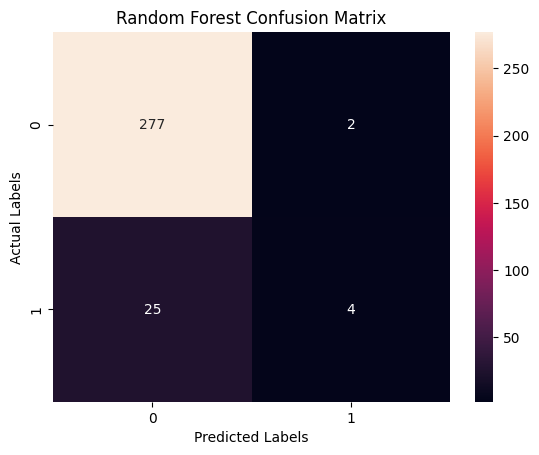

In [ ]:
rf = RandomForestClassifier(n_estimators = 29, max_depth = 11, max_features='sqrt', random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

auc_rf = roc_auc_score(y_test, y_pred_proba_rf[:,1])
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Random Forest Confusion Matrix')

print('----')
print(f'Precision is {precision_rf}')
print(f'Recall is {recall_rf}')
print(f'Fscore is {f1_rf}')
print(f'Accuracy is {accuracy_rf}')
print(f'AUC is {auc_rf}')

### **8.3. Simple Logistic Regression**

Let us try a simple Logistic Regression Model. But first, it is important that we scale our data using a standardscaler!


In [ ]:
X_train.info()

#should we separate binary and continuous columns before training?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 1179 to 194
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   est_age                      924 non-null    float64
 1   male_encoder                 924 non-null    uint8  
 2   cms_disabled_ind             924 non-null    float64
 3   cms_low_income_ind           924 non-null    float64
 4   claim_freq_before_therapy    924 non-null    float64
 5   claim_freq_after_therapy     924 non-null    float64
 6   seizure_diagnosis            924 non-null    float64
 7   pain_diagnosis               924 non-null    float64
 8   fatigue_diagnosis            924 non-null    float64
 9   nausea_diagnosis             924 non-null    float64
 10  hyperglycemia_diagnosis      924 non-null    float64
 11  constipation_diagnosis       924 non-null    float64
 12  diarrhea_diagnosis           924 non-null    float64
 13  earliest_to_visit

In [ ]:
#scale using a standardscaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
X_train_ss

array([[-0.18511463, -0.6140433 , -0.40463312, ..., -0.20041828,
        -0.25396661,  1.11901995],
       [-0.91615169, -0.6140433 , -0.40463312, ...,  0.92192408,
         0.29650836,  2.09692274],
       [ 0.54592243,  1.62854963, -0.40463312, ..., -0.20041828,
         0.16897455,  0.42088915],
       ...,
       [ 0.03078201, -0.6140433 , -0.40463312, ..., -0.20041828,
         0.3653564 ,  1.2358363 ],
       [-0.18511463,  1.62854963, -0.40463312, ..., -0.20041828,
        -0.26007183, -0.21964542],
       [ 0.54592243, -0.6140433 , -0.40463312, ..., -0.20041828,
        -0.24407606,  1.42880033]])

In [ ]:
X_test_ss

array([[ 0.54592243, -0.6140433 , -0.40463312, ..., -0.20041828,
        -0.2577695 , -0.78571779],
       [ 1.03328047, -0.6140433 ,  2.47137458, ...,  0.92192408,
        -0.26141682, -0.93157339],
       [ 0.42408292, -0.6140433 ,  2.47137458, ..., -0.20041828,
        -0.25902157,  0.88702621],
       ...,
       [ 0.30224341,  1.62854963, -0.40463312, ...,  6.53363587,
        -0.26290659, -0.34408209],
       [-1.40350973, -0.6140433 ,  2.47137458, ..., -0.20041828,
        -0.25074144, -0.92966698],
       [-1.0379912 , -0.6140433 , -0.40463312, ..., -0.20041828,
         0.40857012, -0.96114298]])

----
Precision is 0.5882352941176471
Recall is 0.3448275862068966
Fscore is 0.4347826086956522
Accuracy is 0.9155844155844156
AUC is 0.9343715239154616


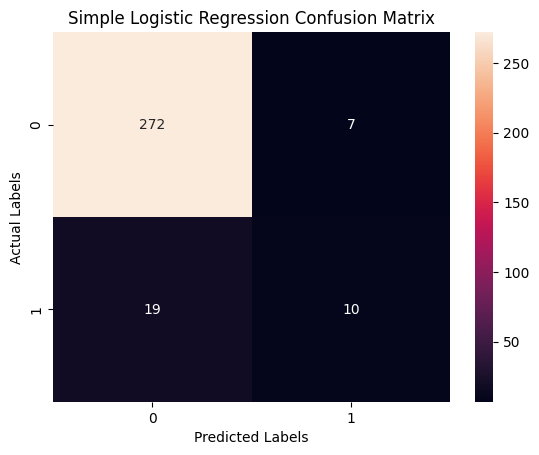

In [ ]:
lr = LogisticRegression(solver = 'liblinear',max_iter= 10000, random_state = 42)
lr.fit(X_train_ss, y_train)

y_pred_lr = lr.predict(X_test_ss)
y_pred_proba_lr = lr.predict_proba(X_test_ss)

precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

auc_lr = roc_auc_score(y_test, y_pred_proba_lr[:,1])
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Simple Logistic Regression Confusion Matrix')

print('----')
print(f'Precision is {precision_lr}')
print(f'Recall is {recall_lr}')
print(f'Fscore is {f1_lr}')
print(f'Accuracy is {accuracy_lr}')
print(f'AUC is {auc_lr}')


### **8.4. L1 Logistic Regression**

Let us try L1-regularization (Lasso) instead of Simple Logistic Regression



----
Precision is 0.5882352941176471
Recall is 0.3448275862068966
Fscore is 0.4347826086956522
Accuracy is 0.9155844155844156
AUC is 0.935854653318502


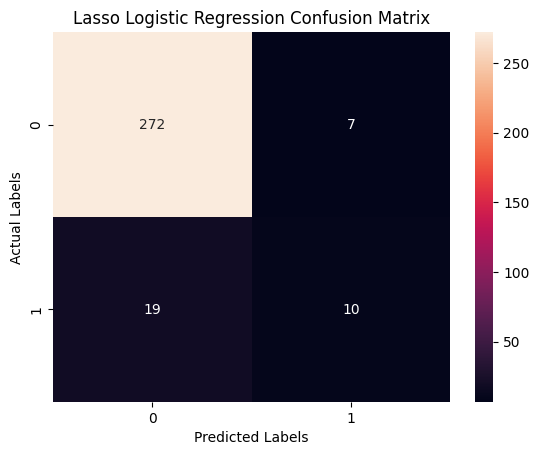

In [ ]:
lr_1 = LogisticRegression(solver = 'liblinear',max_iter= 10000, random_state = 42, penalty='l1')
lr_1.fit(X_train_ss, y_train)

y_pred_lr_1 = lr_1.predict(X_test_ss)
y_pred_proba_lr_1 = lr_1.predict_proba(X_test_ss)

precision_lr_1 = precision_score(y_test, y_pred_lr_1)
recall_lr_1 = recall_score(y_test, y_pred_lr_1)
f1_lr_1 = f1_score(y_test, y_pred_lr_1)
accuracy_lr_1 = accuracy_score(y_test, y_pred_lr_1)

auc_lr_1 = roc_auc_score(y_test, y_pred_proba_lr_1[:,1])
cm = confusion_matrix(y_test, y_pred_lr_1)

sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Lasso Logistic Regression Confusion Matrix')

print('----')
print(f'Precision is {precision_lr_1}')
print(f'Recall is {recall_lr_1}')
print(f'Fscore is {f1_lr_1}')
print(f'Accuracy is {accuracy_lr_1}')
print(f'AUC is {auc_lr_1}')


### **8.5. Ridge Regression**

Let us try the L2 Regularization (Ridge).

----
Precision is 0.5882352941176471
Recall is 0.3448275862068966
Fscore is 0.4347826086956522
Accuracy is 0.9155844155844156
AUC is 0.9343715239154616


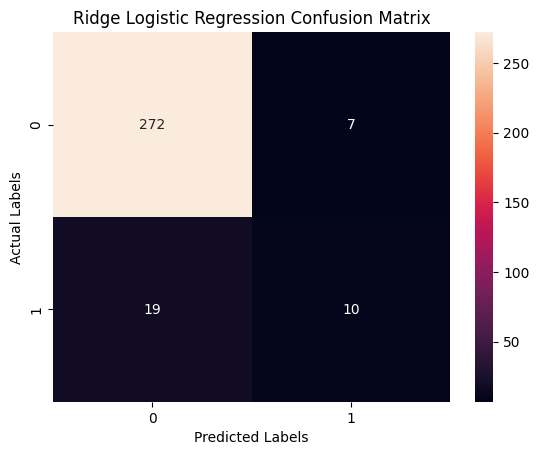

In [ ]:
lr_2 = LogisticRegression(solver = 'liblinear',max_iter= 10000, random_state = 42, penalty='l2')
lr_2.fit(X_train_ss, y_train)

y_pred_lr_2 = lr_2.predict(X_test_ss)
y_pred_proba_lr_2 = lr_2.predict_proba(X_test_ss)

precision_lr_2 = precision_score(y_test, y_pred_lr_2)
recall_lr_2 = recall_score(y_test, y_pred_lr_2)
f1_lr_2 = f1_score(y_test, y_pred_lr_2)
accuracy_lr_2 = accuracy_score(y_test, y_pred_lr_2)

auc_lr_2 = roc_auc_score(y_test, y_pred_proba_lr_2[:,1])
cm = confusion_matrix(y_test, y_pred_lr_2)

sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Ridge Logistic Regression Confusion Matrix')

print('----')
print(f'Precision is {precision_lr_2}')
print(f'Recall is {recall_lr_2}')
print(f'Fscore is {f1_lr_2}')
print(f'Accuracy is {accuracy_lr_2}')
print(f'AUC is {auc_lr_2}')


We can see that Ridge and Lasso do not improve the results of a simple logistic regression by much. The reason is that we do not have a lot of features. Next, we try and include more features in the model so that it can learn better.

## **Section 9: ROC AUC Curves and Model Comparison Based on a Single Train Test Split**

Before we proceed with cross validation, we plot the ROC AUC curves for each of the four models developed earlier for a single train test split and we compare the results. Since AUC is the chosen metric by Humana, we can about maximizing the AUC score.

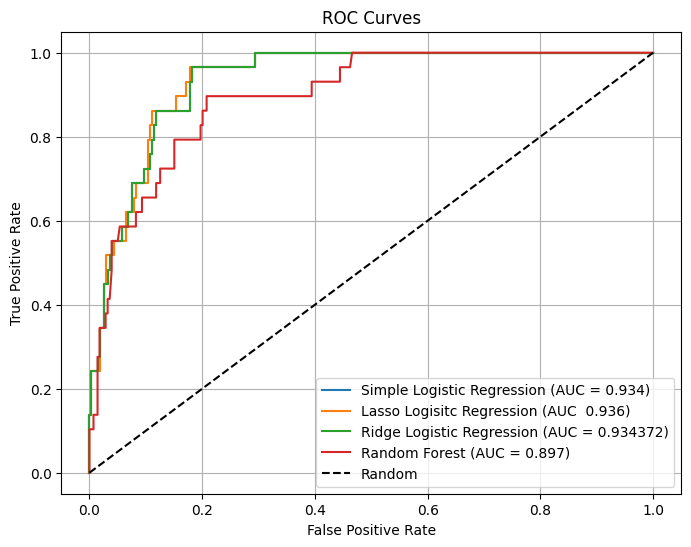

In [ ]:
#To be able to plot the roc curves for each model, we first find the the false positive rate and the true positive rate for each model
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba_lr[:,1])
lr_auc = roc_auc_score(y_test, y_pred_proba_lr[:,1])

lr1_fpr, lr1_tpr, _ = roc_curve(y_test, y_pred_proba_lr_1[:,1])
lr_1_auc = roc_auc_score(y_test, y_pred_proba_lr_1[:,1])

lr_2_fpr, lr_2_tpr, _ = roc_curve(y_test, y_pred_proba_lr_2[:,1])
lr_2_auc = roc_auc_score(y_test, y_pred_proba_lr_2[:,1])

rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba_rf[:,1])
rf_auc = roc_auc_score(y_test, y_pred_proba_rf[:,1])

#plot

plt.figure(figsize=(8,6))
plt.plot(lr_fpr, lr_tpr, label = f'Simple Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(lr1_fpr, lr1_tpr, label = f'Lasso Logisitc Regression (AUC  {lr_1_auc:.3f})')
plt.plot(lr_2_fpr, lr_2_tpr, label = f'Ridge Logistic Regression (AUC = {lr_2_auc:3f})')
plt.plot(rf_fpr, rf_tpr, label = f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## **Section 10: Cross Validation**

Recall that when we split using the `stratified_shuffle_split`, we specified the number of splits to be 1. However, it might be the case where the results we got (i.e. the confusion matrix and the socores) are because of the randomness of this split. In other words, we might have been "lucky" with our predictions. To validate that, we use cross validation on all the models that we have developed earlier and see how they perform if we run them on multiple train_test_splits.



In [ ]:
#Let us split the data into train and test sets

strat_shuffle_split = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state=42)

In [ ]:
train_idx_cross_val = []
test_idx_cross_val = []

for train_idx, test_idx in strat_shuffle_split.split(X,y):
  train_idx_cross_val.append(train_idx)
  test_idx_cross_val.append(test_idx)

In [ ]:
train_idx_cross_val[0]

array([ 452,  745, 1023,  660, 1168,  332,  973,  793,  197,  870, 1212,
         56,  258,  351, 1044,  775, 1004,  193,   32,  562,  664,  104,
        185,  285,  489,  567,  444,   52,   50,  320,   98,  779,  291,
         26,  910,  316,  329, 1228,  129,  816,  111,  924,  653,   65,
        303,  670, 1011,   61,   95,  370,   76,  128,  136, 1170,  678,
       1120,  789,  312,  748,  259,  459,  516,  173,   85,  371,  442,
        694,  386,  213,  834,  915,  339,  137,   40,  436,  204, 1153,
         86,  607,  403,  667, 1006,  791,  892,  936,   35,  765,  510,
        991,  529,  922,  890,  600,  898,   93,  376,  218,  651,  152,
        597, 1036,  492,  539,  393,  730,  470,  355,  737,  578,  912,
        390, 1191,  176,   68,  368,  304, 1141,  447,   55,  537,  740,
        964, 1017, 1214, 1125, 1076, 1067,  422, 1045,   63, 1167,  817,
        688,  544, 1103, 1129,  668,  807,  785,   99,  695, 1185,  699,
        278,  882,  662,  691,  917,  750,   30,  4

In [ ]:
test_idx_cross_val[0]

array([ 820, 1053,  875,  913,  412,  634,  523,  888, 1201, 1122,  823,
          5,  560,  623,  604,  752,  754, 1038,  424,  843,  672,  455,
        871,  313,  781,  747,  419,  417, 1194,  684,  692,  911,  918,
        884,  897, 1208, 1176,  742, 1117, 1019,  377,  887, 1007,  396,
        707, 1073,  279,  430,  923,  175,  818,  715,  713,  877,  990,
        182, 1134,  960,  824,  943,  348,   22,  207, 1057,  147,  257,
        724,  445,  238, 1215,  840,   51,  734,  961,  219, 1169,  622,
        625, 1110,   38,  814, 1161,  365,   29,  635, 1200,  886,  855,
        384, 1144,  110,  810,  520, 1071,  874,  547,  534,  287,  638,
         89,  757,  508, 1227,  435,  521,  226,  327,  946,  949,  186,
        689,  220, 1051,  507,  319,   94,  450, 1037,  995,  241, 1046,
       1172, 1084,  310,  812,  248,  761,  615,  286, 1151, 1089,  925,
         37,  654,   70,  441,  297,  808,   15,  774,  663,  205,  968,
        770,  460,  698,  559, 1123,  988,  429,   

We can see that each index of the cross val list is a list by itself (of indices for train and test splits)

### **10.1. Simple Logistic Regression Scores**

Let us calculate the scores of a simple logistic regression using cross validation

In [ ]:
accuracy_lr_cross_val = []
recall_lr_cross_val = []
precision_lr_cross_val = []
fscore_lr_cross_val = []
auc_lr_cross_val=[]

for i in range(5):
  X_train = X.iloc[train_idx_cross_val[i]]
  y_train = y.iloc[train_idx_cross_val[i]]

  X_test = X.iloc[test_idx_cross_val[i]]
  y_test = y.iloc[test_idx_cross_val[i]]

  X_train_ss = ss.fit_transform(X_train)
  X_test_ss = ss.transform(X_test)

  lr = lr.fit(X_train_ss, y_train)

  y_pred = lr.predict(X_test_ss)
  y_pred_proba = lr.predict_proba(X_test_ss)

  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  fscore = f1_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

  accuracy_lr_cross_val.append(accuracy)
  recall_lr_cross_val.append(recall)
  precision_lr_cross_val.append(precision)
  fscore_lr_cross_val.append(fscore)
  auc_lr_cross_val.append(auc_score)

In [ ]:
#do a dataframe to append the results of the model
df_lr_cross_val = pd.DataFrame(columns = ['Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC'] )
df_lr_cross_val['Accuracy'] = accuracy_lr_cross_val
df_lr_cross_val['Recall'] = recall_lr_cross_val
df_lr_cross_val['Precision'] = precision_lr_cross_val
df_lr_cross_val['F1-score'] = fscore_lr_cross_val
df_lr_cross_val['AUC'] = auc_lr_cross_val

df_lr_cross_val

,Accuracy,Recall,Precision,F1-score,AUC
0,0.914980,0.347826,0.571429,0.432432,0.941964
1,0.898785,0.217391,0.416667,0.285714,0.850155
2,0.910931,0.347826,0.533333,0.421053,0.859278
3,0.906883,0.304348,0.500000,0.378378,0.887616
4,0.927126,0.391304,0.692308,0.500000,0.901203


In [ ]:
# print the means
print(f'The mean accuracy for Simple Logistic Model is: {np.mean(accuracy_lr_cross_val)}')
print(f'The mean recall for Simple Logistic Model is: {np.mean(recall_lr_cross_val)}')
print(f'The mean precision for Simple Logistic Model is: {np.mean(precision_lr_cross_val)}')
print(f'The mean f1-score for Simple Logistic Model is: {np.mean(fscore_lr_cross_val)}')
print(f'The mean auc for Simple Logistic Model is: {np.mean(auc_lr_cross_val)}')

The mean accuracy for Simple Logistic Model is: 0.9117408906882591
The mean recall for Simple Logistic Model is: 0.32173913043478264
The mean precision for Simple Logistic Model is: 0.5427472527472528
The mean f1-score for Simple Logistic Model is: 0.40351554562080877
The mean auc for Simple Logistic Model is: 0.8880434782608697


### **10.2. L1 Logistic**

In [ ]:
accuracy_lr1_cross_val = []
recall_lr1_cross_val = []
precision_lr1_cross_val = []
fscore_lr1_cross_val = []
auc_lr1_cross_val = []

for i in range(5):
    X_train = X.iloc[train_idx_cross_val[i]]
    y_train = y.iloc[train_idx_cross_val[i]]

    X_test = X.iloc[test_idx_cross_val[i]]
    y_test = y.iloc[test_idx_cross_val[i]]

    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    #fit the model
    lr_1.fit(X_train_ss, y_train)

    #Predict
    y_pred = lr_1.predict(X_test_ss)
    y_pred_proba = lr_1.predict_proba(X_test_ss)

    #scores
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

    #append
    accuracy_lr1_cross_val.append(accuracy)
    recall_lr1_cross_val.append(recall)
    precision_lr1_cross_val.append(precision)
    fscore_lr1_cross_val.append(fscore)
    auc_lr1_cross_val.append(auc_score)

In [ ]:
#do a dataframe to append the results of the model
df_lr1_cross_val = pd.DataFrame(columns = ['Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC'] )
df_lr1_cross_val['Accuracy'] = accuracy_lr1_cross_val
df_lr1_cross_val['Recall'] = recall_lr1_cross_val
df_lr1_cross_val['Precision'] = precision_lr1_cross_val
df_lr1_cross_val['F1-score'] = fscore_lr1_cross_val
df_lr1_cross_val['AUC'] = auc_lr1_cross_val

df_lr1_cross_val

,Accuracy,Recall,Precision,F1-score,AUC
0,0.914980,0.347826,0.571429,0.432432,0.942935
1,0.898785,0.217391,0.416667,0.285714,0.851708
2,0.906883,0.304348,0.500000,0.378378,0.855008
3,0.906883,0.304348,0.500000,0.378378,0.894216
4,0.927126,0.391304,0.692308,0.500000,0.906056


In [ ]:
# print the means
print(f'The mean accuracy for Lasso Logistic Model is: {np.mean(accuracy_lr1_cross_val)}')
print(f'The mean recall for Lasso Logistic Model is: {np.mean(recall_lr1_cross_val)}')
print(f'The mean precision for Lasso Logistic Model is: {np.mean(precision_lr1_cross_val)}')
print(f'The mean f1-score for Lasso Logistic Model is: {np.mean(fscore_lr1_cross_val)}')
print(f'The mean auc for Lasso Logistic Model is: {np.mean(auc_lr1_cross_val)}')

The mean accuracy for Lasso Logistic Model is: 0.9109311740890689
The mean recall for Lasso Logistic Model is: 0.31304347826086953
The mean precision for Lasso Logistic Model is: 0.5360805860805862
The mean f1-score for Lasso Logistic Model is: 0.394980694980695
The mean auc for Lasso Logistic Model is: 0.8899844720496894


### **10.3. L2 Logistic**

In [ ]:
accuracy_lr2_cross_val = []
recall_lr2_cross_val = []
precision_lr2_cross_val = []
fscore_lr2_cross_val = []
auc_lr2_cross_val = []

for i in range(5):
    X_train = X.iloc[train_idx_cross_val[i]]
    y_train = y.iloc[train_idx_cross_val[i]]

    X_test = X.iloc[test_idx_cross_val[i]]
    y_test = y.iloc[test_idx_cross_val[i]]

    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    #fit the model
    lr_2.fit(X_train, y_train)

    #Predict
    y_pred = lr_2.predict(X_test_ss)
    y_pred_proba = lr_2.predict_proba(X_test_ss)

    #scores
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

    #append
    accuracy_lr2_cross_val.append(accuracy)
    recall_lr2_cross_val.append(recall)
    precision_lr2_cross_val.append(precision)
    fscore_lr2_cross_val.append(fscore)
    auc_lr2_cross_val.append(auc_score)

In [ ]:
#do a dataframe to append the results of the model
df_lr2_cross_val = pd.DataFrame(columns = ['Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC'] )
df_lr2_cross_val['Accuracy'] = accuracy_lr2_cross_val
df_lr2_cross_val['Recall'] = recall_lr2_cross_val
df_lr2_cross_val['Precision'] = precision_lr2_cross_val
df_lr2_cross_val['F1-score'] = fscore_lr2_cross_val
df_lr2_cross_val['AUC'] = auc_lr2_cross_val

df_lr2_cross_val

,Accuracy,Recall,Precision,F1-score,AUC
0,0.862348,0.739130,0.377778,0.500000,0.876747
1,0.862348,0.434783,0.322581,0.370370,0.814441
2,0.850202,0.434783,0.294118,0.350877,0.831910
3,0.866397,0.434783,0.333333,0.377358,0.809589
4,0.886640,0.521739,0.413793,0.461538,0.882958


In [ ]:
# print the means
print(f'The mean accuracy for Ridge Logistic Model is: {np.mean(accuracy_lr2_cross_val)}')
print(f'The mean recall for Ridge Logistic Model is: {np.mean(recall_lr2_cross_val)}')
print(f'The mean precision for Ridge Logistic Model is: {np.mean(precision_lr2_cross_val)}')
print(f'The mean f1-score for Ridge Logistic Model is: {np.mean(fscore_lr2_cross_val)}')
print(f'The mean auc for Ridge Logistic Model is: {np.mean(auc_lr2_cross_val)}')

The mean accuracy for Ridge Logistic Model is: 0.8655870445344129
The mean recall for Ridge Logistic Model is: 0.5130434782608695
The mean precision for Ridge Logistic Model is: 0.34832050135590015
The mean f1-score for Ridge Logistic Model is: 0.41202890309146517
The mean auc for Ridge Logistic Model is: 0.8431288819875776


In [ ]:
accuracy_rf_cross_val = []
recall_rf_cross_val = []
precision_rf_cross_val = []
fscore_rf_cross_val = []
auc_rf_cross_val = []

for i in range(5):
    X_train = X.iloc[train_idx_cross_val[i]]
    y_train = y.iloc[train_idx_cross_val[i]]

    X_test = X.iloc[test_idx_cross_val[i]]
    y_test = y.iloc[test_idx_cross_val[i]]

    #For the sake of computation, let us take the best parameters of the random forest defined earlier
    rf = RandomForestClassifier(n_estimators=29, max_depth=11, max_features='sqrt')
    #fit the model
    rf = rf.fit(X_train, y_train)

    #Predict
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)

    #scores
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

    #append
    accuracy_rf_cross_val.append(accuracy)
    recall_rf_cross_val.append(recall)
    precision_rf_cross_val.append(precision)
    fscore_rf_cross_val.append(fscore)
    auc_rf_cross_val.append(auc_score)

In [ ]:
#do a dataframe to append the results of the model
df_rf_cross_val = pd.DataFrame(columns = ['Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC'] )
df_rf_cross_val['Accuracy'] = accuracy_rf_cross_val
df_rf_cross_val['Recall'] = recall_rf_cross_val
df_rf_cross_val['Precision'] = precision_rf_cross_val
df_rf_cross_val['F1-score'] = fscore_rf_cross_val
df_rf_cross_val['AUC'] = auc_rf_cross_val

df_rf_cross_val

,Accuracy,Recall,Precision,F1-score,AUC
0,0.931174,0.347826,0.800000,0.484848,0.912655
1,0.914980,0.260870,0.600000,0.363636,0.886646
2,0.919028,0.173913,0.800000,0.285714,0.885481
3,0.914980,0.173913,0.666667,0.275862,0.876747
4,0.931174,0.391304,0.750000,0.514286,0.934783


In [ ]:
# print the means
print(f'The mean accuracy for Random Forest Model is: {np.mean(accuracy_rf_cross_val)}')
print(f'The mean recall for Random Forest Model is: {np.mean(recall_rf_cross_val)}')
print(f'The mean precision for Random Forest Model is: {np.mean(precision_rf_cross_val)}')
print(f'The mean f1-score for Random Forest Model is: {np.mean(fscore_rf_cross_val)}')
print(f'The mean auc for Random Forest Model is: {np.mean(auc_rf_cross_val)}')

The mean accuracy for Random Forest Model is: 0.9222672064777327
The mean recall for Random Forest Model is: 0.26956521739130435
The mean precision for Random Forest Model is: 0.7233333333333334
The mean f1-score for Random Forest Model is: 0.38486938349007316
The mean auc for Random Forest Model is: 0.8992624223602486


## **Section 11: Dashboards**

### **11.1. Feature Importance**

We know that there are two types of models: Interpretable models and non-interpretable models. RandomForest is an example of an uniterpretable model. It is like a blackbox. All we get from it is predictions. But when it comes to understand what is happening under the hood to come up with these predictions, it is hard without advanced techniques like column permutations.

Logistic Regression, however, has the advantage of interpretability. We can calculate the coefficients of a logist regression function to determine which features are driving predictions. This is what we do here.

In [ ]:
features = list(df_final.columns)
features.remove('tgt_ade_dc_ind')
features #length = 27

['est_age',
 'male_encoder',
 'cms_disabled_ind',
 'cms_low_income_ind',
 'num_visits_before_therapy',
 'num_visits_after_therapy',
 'seizure_diagnosis',
 'pain_diagnosis',
 'fatigue_diagnosis',
 'nausea_diagnosis',
 'hyperglycemia_diagnosis',
 'constipation_diagnosis',
 'diarrhea_diagnosis',
 'claim_freq_before_therapy',
 'claim_freq_after_therapy',
 'earliest_to_visit_days',
 'num_services_before_therapy',
 'num_services_after_therapy',
 'count_drug_classes_unique',
 'count_drug_classes',
 'ddi_ind',
 'anticoag_ind',
 'diarrhea_treat_ind',
 'nausea_treat_ind',
 'seizure_treat_ind',
 'average_cost_before_therapy',
 'average_cost_after_therapy']

In [ ]:
lr.coef_[0]

array([-2.02634243e-02,  2.92574567e-02, -7.00414219e-02,  5.35587883e-02,
        3.12630481e-04, -1.54858867e-02,  2.28468353e-02, -1.80198959e-01,
        2.85448885e-02,  2.68107450e-03, -3.82181807e-02,  3.71409465e-02,
        2.93821672e-02,  5.50650879e-02,  1.81005335e+00, -1.86414288e-02,
        2.88004319e-02, -3.91105731e-02,  1.62689971e-01, -2.77501840e-02,
       -3.60688225e-01,  7.19487565e-02,  2.45423500e-02,  8.25892869e-02,
        1.11150888e-01, -2.81254554e-04,  2.08564929e-03])

In [ ]:
lr_1.coef_[0]

array([-2.32154807e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.96722262e-04, -1.68849213e-02,  2.08410215e-02, -1.40776616e-01,
        2.72198538e-02,  3.51533225e-03, -3.98461932e-02,  3.65901188e-02,
        2.91479781e-02,  2.43633970e-02,  2.01347097e+00, -1.84412868e-02,
        2.52307894e-02, -3.73453541e-02,  1.53626159e-01, -2.39439139e-02,
       -3.34558704e-01,  6.46340509e-02,  4.19169516e-04,  7.32555297e-02,
        9.08513244e-02, -3.03702025e-04,  2.86664308e-03])

In [ ]:
lr_2.coef_[0]

array([-2.02634243e-02,  2.92574567e-02, -7.00414219e-02,  5.35587883e-02,
        3.12630481e-04, -1.54858867e-02,  2.28468353e-02, -1.80198959e-01,
        2.85448885e-02,  2.68107450e-03, -3.82181807e-02,  3.71409465e-02,
        2.93821672e-02,  5.50650879e-02,  1.81005335e+00, -1.86414288e-02,
        2.88004319e-02, -3.91105731e-02,  1.62689971e-01, -2.77501840e-02,
       -3.60688225e-01,  7.19487565e-02,  2.45423500e-02,  8.25892869e-02,
        1.11150888e-01, -2.81254554e-04,  2.08564929e-03])

In [ ]:
len(lr_2.coef_[0]) #equal to the length of the features

27

In [ ]:
#Let us put them all in a dataframe and then export them to tableau for visualizations

values_lr = lr.coef_[0]
values_lr1 = lr_1.coef_[0]
values_lr2 = lr_2.coef_[0]

feature_importances = pd.DataFrame(columns = ['Feature', 'lr', 'lr_l1', 'lr_l2'])
feature_importances['Feature']=features
feature_importances['lr']=values_lr
feature_importances['lr_l1']=values_lr1
feature_importances['lr_l2']=values_lr2
feature_importances

,Feature,lr,lr_l1,lr_l2
0,est_age,-0.020263,-0.023215,-0.020263
1,male_encoder,0.029257,0.000000,0.029257
2,cms_disabled_ind,-0.070041,0.000000,-0.070041
3,cms_low_income_ind,0.053559,0.000000,0.053559
4,num_visits_before_therapy,0.000313,0.000597,0.000313
5,num_visits_after_therapy,-0.015486,-0.016885,-0.015486
6,seizure_diagnosis,0.022847,0.020841,0.022847
7,pain_diagnosis,-0.180199,-0.140777,-0.180199
8,fatigue_diagnosis,0.028545,0.027220,0.028545
9,nausea_diagnosis,0.002681,0.003515,0.002681


In [ ]:
#Export to excel

feature_importances.to_excel('/content/drive/My Drive/feature_importance.xlsx', index = False)

### **11.2. Dashboard for df_final**

Let us build a dashboard for df_final

## **Section 11: Ideas for Visualizations**

In this section, we discuss metrics to track and possible ideas for visualizations:

- Visualize how the ade_diagnosis affects the target_label.
- Visualize Feature Importance by Lasso

In [ ]:
target_train.shape

(1232, 11)

In [ ]:
medclms_train.shape

(100159, 27)

In [ ]:
rxclms_train.shape

(32133, 24)